# GA4データ抽出

In [ ]:
#@title 初期設定

import calendar
import pandas as pd
import pytz
import re
from datetime import datetime, timedelta, timezone
from dateutil.relativedelta import relativedelta
from IPython.display import clear_output, display

try:
    from megaton import start
except ModuleNotFoundError:
    %pip install -U -q git+https://github.com/mak00s/megaton
    from megaton import start

def get_past_date(n_days=None, n_months=None, first_or_last=None, timezone="Asia/Tokyo", date_format="%Y-%m-%d"):
    """
    Returns today's date, the first day of the current month, a date N days ago,
    or the first/last day of N months ago in a specified format.

    Args:
        n_days (int, optional): The number of days ago. Default is None.
        n_months (int, optional): The number of months ago. Default is None.
        first_or_last (str, optional): 'first' or 'last' to specify the first or last day of the month. Default is None.
        timezone (str): Timezone for the calculation. Default is 'Asia/Tokyo'.
        date_format (str): The desired output date format. Default is '%Y-%m-%d'.

    Returns:
        str: The calculated date in the specified format.

    Raises:
        ValueError: If both 'n_days' and 'n_months' are provided, or if 'first_or_last' is invalid.
    """
    if n_days is not None and n_months is not None:
        raise ValueError("Specify either 'n_days' or 'n_months', but not both.")
    if first_or_last and first_or_last not in ['first', 'last']:
        raise ValueError("Invalid value for 'first_or_last'. Use 'first' or 'last'.")

    # Current datetime in the specified timezone
    now = datetime.now(pytz.timezone(timezone))

    if n_days is not None:
        # Calculate N days ago
        result_date = now - timedelta(days=n_days)
    elif n_months is not None:
        # Calculate the first or last day of N months ago
        year = now.year
        month = now.month - n_months
        while month <= 0:
            year -= 1
            month += 12
        if first_or_last == 'first':
            result_date = datetime(year, month, 1, tzinfo=pytz.timezone(timezone))
        elif first_or_last == 'last':
            last_day = calendar.monthrange(year, month)[1]
            result_date = datetime(year, month, last_day, tzinfo=pytz.timezone(timezone))
        else:
            # Default to the start of the month if first_or_last is None
            result_date = datetime(year, month, 1, tzinfo=pytz.timezone(timezone))
    else:
        # Default to today or the first day of the current month
        if first_or_last == 'first':
            result_date = datetime(now.year, now.month, 1, tzinfo=pytz.timezone(timezone))
        else:
            result_date = now

    return result_date.strftime(date_format)

def duplicate_sheet(source_sheet_title, new_sheet_name, cell_update=None):
    """
    Duplicates a Google Sheets worksheet and updates a specific cell in the new sheet.

    Args:
        source_sheet_title (str): The title of the worksheet to duplicate.
        new_sheet_name (str): The title for the new duplicated worksheet.
        cell_update (dict, optional): A dictionary specifying a cell to update, e.g., {"cell": "B1", "value": "some_value"}.
    """
    try:
        # Get the source worksheet
        source_worksheet = mg.gs._driver.worksheet(source_sheet_title)

        # Duplicate the worksheet
        mg.gs._driver.duplicate_sheet(
            source_worksheet.id,
            new_sheet_name=new_sheet_name
        )
        logger.info(f"Worksheet '{new_sheet_name}' duplicated from '{source_sheet_title}'.")

        # Update a specific cell in the duplicated sheet if specified
        if cell_update:
            mg.gs.sheet._driver.update_acell(cell_update["cell"], cell_update["value"])
            logger.info(f"Cell '{cell_update['cell']}' updated with value '{cell_update['value']}' in '{new_sheet_name}'.")
    except Exception as e:
        logger.error(f"Error duplicating worksheet '{source_sheet_title}' to '{new_sheet_name}': {e}")

def save_to_google_sheet(gs_url, sheet_name, df, sort_by=None):
    """
    Saves a DataFrame to a Google Sheet. If the sheet exists, it clears the existing data;
    otherwise, it creates a new sheet. Adjusts column widths based on the data and freezes the first row.

    Args:
        gs_url (str): The URL of the Google Sheets document.
        sheet_name (str): The name of the sheet to save the data.
        df (pd.DataFrame): The DataFrame to save.
    """
    def calculate_pixel_size(value, single_byte_multiplier=7, multi_byte_multiplier=14):
        """
        Calculates the pixel size for a given value, accounting for multi-byte characters.

        Args:
            value (str): The string value to calculate the size for.
            single_byte_multiplier (int): Width multiplier for single-byte characters.
            multi_byte_multiplier (int): Width multiplier for multi-byte characters.

        Returns:
            int: The calculated pixel size.
        """
        total_width = 0
        for char in str(value):
            if ord(char) < 128:  # Single-byte character
                total_width += single_byte_multiplier
            else:  # Multi-byte character
                total_width += multi_byte_multiplier
        return total_width

    # Sort the DataFrame if specified
    if sort_by:
        df = df.sort_values(by=sort_by, ascending=False)

    if mg.open.sheet(gs_url):
        try:
            # Try to create a new sheet
            mg.gs._driver.add_worksheet(title=sheet_name, rows=10, cols=10)
        except Exception:
            # If the sheet already exists, select it and clear the data
            mg.gs.sheet.select(sheet_name)
            mg.gs.sheet.clear()

        # Save the DataFrame to the sheet
        mg.save.to.sheet(df=df, sheet_name=sheet_name)

        # Get the sheet object and its ID
        sheet = mg.gs._driver.worksheet(sheet_name)
        sheet_id = sheet.id

        # Calculate column widths
        column_widths = []
        for col_name in df.columns:
            max_length = max(
                df[col_name].astype(str).map(
                    lambda x: calculate_pixel_size(x)
                ).max(),
                calculate_pixel_size(col_name)
            )
            pixel_size = max(min(max_length, 500), 50)  # Minimum width: 50, Maximum width: 500
            column_widths.append(pixel_size)

        # Prepare batch update requests for column resizing and freezing the first row
        requests = [
            # Column resizing
            {
                "updateDimensionProperties": {
                    "range": {
                        "sheetId": sheet_id,
                        "dimension": "COLUMNS",
                        "startIndex": i,
                        "endIndex": i + 1
                    },
                    "properties": {"pixelSize": column_widths[i]},
                    "fields": "pixelSize"
                }
            }
            for i in range(len(column_widths))
        ]

        # Add request to freeze the first row
        requests.append({
            "updateSheetProperties": {
                "properties": {
                    "sheetId": sheet_id,
                    "gridProperties": {"frozenRowCount": 1}
                },
                "fields": "gridProperties.frozenRowCount"
            }
        })

        # Execute batch update
        mg.gs._driver.batch_update({"requests": requests})
        print(f"Data successfully saved to the sheet: {sheet_name}, column widths adjusted, and first row frozen.")
    else:
        print("Failed to open the Google Sheets document.")

def update_sheets_cells(cells_to_update):
    """
    Updates specific cells across multiple sheets in Google Sheets with provided values.

    Args:
        cells_to_update (dict): A dictionary where keys are sheet names, and values are
                                dictionaries mapping cell names to their values.

                                Example:
                                {
                                    "Page": {"I1": From, "K1": __To},
                                    "Summary": {"A1": "Report Start", "B1": From}
                                }
    """
    try:
        for sheet_name, updates in cells_to_update.items():
            # Select the target sheet
            mg.gs.sheet.select(sheet_name)

            # Update the specified cells with the provided values
            for cell, value in updates.items():
                mg.gs.sheet._driver.update_acell(cell, value)

            print(f"Successfully updated sheet '{sheet_name}' with updates: {updates}")
    except Exception as e:
        print(f"An error occurred while updating the sheets: {e}")

CREDS_PATH = "/nbs/key/sa-shiseido-corp-dts.json"
mg = start.Megaton(CREDS_PATH, use_ga3=False)

GA4_ACCOUNT = '151965783'  #param {type:"string"}
GA4_PROPERTY = '334854563'  #param {type:"string"}
mg.ga['4'].account.select(GA4_ACCOUNT)
mg.ga['4'].property.select(GA4_PROPERTY)

# BQ準備
GCP_PROJECT = "shiseido-corp-1872"  #param {type:"string"}
bq = mg.launch_bigquery(GCP_PROJECT)

clear_output()

#markdown サイト定義
content = [ # コンテンツカテゴリの定義
    ("Top", "^/(en|jp)/($|\?)"),
    ("Company", "^/(en|jp)/(americas|apac|china|company|emea|japan|sports|tr)/"),
    ("Brand", "^/(en|jp)/brands/"),
    ("Sustainability", "^/(en|jp)/sustainability/"),
    ("Innovation", "^/(en|jp)/rd/"),
    ("Careers", "^/(en|jp)/(careers|recruit|scp/careers)"),
    ("Investors", "^/(en|jp)/ir/"),
    ("News Releases", "^/(en|jp)/news/"),
]

#markdown 書き込むGoogle SheetsのURL
URL1 = "https://docs.google.com/spreadsheets/d/1pDMKBzIc-1brDQRRjEtWqJb0ZfONqReiXTSHJ9iqKTU" #アクセス推移
URL2 = "https://docs.google.com/spreadsheets/d/1dM7PSHS48lBKTEuXB1xJDV5rw4qDeBWUWdZ_itqN6sw" #入口コンテンツ
URL3 = "https://docs.google.com/spreadsheets/d/1UjooCBtrqEbmQK5uBZlWaVbVTGvvgeNPtP-IdLPIVG8" #Shiseido Talks
URL4 = "https://docs.google.com/spreadsheets/d/1ZHXZBgtsGZmiMdmO2NnRP31p6QU-9lyqVOW4IdybzuY" #News Release
URL5 = "https://docs.google.com/spreadsheets/d/1v1oL3kq6dhWGmuFsk870YSrcBscJkfq6Rx7lCeQWNCE" #検索ワード
URL6 = "https://docs.google.com/spreadsheets/d/1G-yKox0_ZIp3NG_agkSFplsjqW5BrH4QbjVwsItp8_E" #TOPクリック
URL8 = "https://docs.google.com/spreadsheets/d/1mVXEbJ-DxWA25oCpOio9XeEA7ae0PI3mZrpwr8RH8Co"

# レポート期間
# now = datetime.now(pytz.timezone("Asia/Tokyo"))

# 先月
LM_From = get_past_date(n_months=1, first_or_last='first')
LM___To = get_past_date(n_months=1, first_or_last='last')
print(f"先月の期間は{LM_From} - {LM___To}")

# 今月
TM_From = get_past_date(first_or_last='first')
TM___To = get_past_date(first_or_last='last')
if TM___To < TM_From:
    TM___To = TM_From
print(f"直近の期間は{TM_From} - {TM___To}")

# 年間
YR___To = LM___To
YR_From = get_past_date(n_months=13, first_or_last='first')
print(f"13ヶ月の期間は{YR_From} - {YR___To}")
YR_From12 = get_past_date(n_months=12, first_or_last='first')
print(f"12ヶ月の期間は{YR_From12} - {YR___To}")

print("準備ができました。次のセルへ進んでください。")

先月の期間は2025-11-01 - 2025-11-30
直近の期間は2025-12-01 - 2025-12-02
13ヶ月の期間は2024-11-01 - 2025-11-30
12ヶ月の期間は2024-12-01 - 2025-11-30
準備ができました。次のセルへ進んでください。


## 01. アクセス推移

In [ ]:
#@title Corp：先月
mg.report.set_dates(LM_From, LM___To)

mg.report.run(
    d = ["contentGroup", ("customEvent:lang", "language")],
    m = [
        "eventCount",
        "sessions",
        "totalUsers",
        "averageSessionDuration",
        "userEngagementDuration",
    ],
    filter_d = "eventName==page_view;contentGroup!@not set",
    sort = "-sessions")

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_corp_m" #@param {type:"string"}

if mg.open.sheet(URL1):
    mg.save.to.sheet(sheet_name=Sheet)  # 上書きする

Googleスプレッドシート「01. アクセス推移」を開きました。
「_corp_m」シートを選択しました。
データを「_corp_m」シートへ反映しました。


In [ ]:
#@title Corp：先月〜昨日daily
mg.report.set_dates(LM_From, TM___To)

mg.report.run(
    d = ["date", "contentGroup", ("customEvent:lang", "language")],
    m = ["sessions"],
    filter_d = "eventName==page_view;contentGroup!@not set",
    sort = "date")

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_corp_m-d" #@param {type:"string"}

if mg.open.sheet(URL1):
    mg.save.to.sheet(sheet_name=Sheet)

# mg.gs.sheet.select("Corp先月日別")
# mg.gs.sheet._driver.update_acell("E1", LM_From)
# mg.gs.sheet._driver.update_acell("H1", LM___To)
update_sheets_cells({"Corp先月日別": {"F1": LM_From, "I1": LM___To}})

Googleスプレッドシート「01. アクセス推移」を開きました。
「_corp_m-d」シートを選択しました。
データを「_corp_m-d」シートへ反映しました。
Successfully updated sheet 'Corp先月日別' with updates: {'F1': '2025-11-01', 'I1': '2025-11-30'}


In [ ]:
#@title Corp：daily Page
mg.report.set_dates(LM_From, TM___To)

# Define content groups as a dict: {label: match_condition}
content_groups = {
    "企業情報": "会社案内",
    "ブランド": "ブランド",
    "サステナビリティ": "サステナビリティ",
    "イノベーション": "研究",  # using partial match due to delimiter issues
    "採用情報": "採用情報",
    "投資家情報": "投資家情報",
    "ニュースリリース": "ニュースリリース"
}

all_data = []

for group_name, match_text in content_groups.items():
    # Use full URL with query string for ニュースリリース
    page_dim = ("pagePathPlusQueryString", "page") if group_name == "ニュースリリース" else ("pagePath", "page")

    # Step 1: Get all pages in this content group
    mg.report.run(
        d=[page_dim, ("customEvent:lang", "language")],
        m=["sessions"],
        filter_d=f"eventName==page_view;contentGroup=@{match_text}",
        sort="-sessions"
    )
    df_all_pages = mg.report.data

    if df_all_pages.empty:
        continue

    # Step 2: Split by language and get top 5 per language
    for lang in ["JP", "EN"]:
        df_lang = df_all_pages[df_all_pages["language"] == lang]
        top_pages = df_lang["page"].head(5).tolist()

        if not top_pages:
            continue

        page_regex = "|".join(re.escape(p) + "$" for p in top_pages)

        # Step 3: Fetch daily sessions for those pages
        mg.report.run(
            d=["date", page_dim],
            m=["sessions"],
            filter_d=f"eventName==page_view;{page_dim[0]}=~({page_regex})",
            sort="date"
        )
        df_daily = mg.report.data.copy()
        df_daily["contentGroup"] = group_name
        df_daily["language"] = lang

        all_data.append(df_daily)

# Final result
df_final = pd.concat(all_data, ignore_index=True)

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_corp_page-d" #@param {type:"string"}

if mg.open.sheet(URL1):
    mg.save.to.sheet(df=df_final, sheet_name=Sheet)

Googleスプレッドシート「01. アクセス推移」を開きました。
「_corp_page-d」シートを選択しました。
データを「_corp_page-d」シートへ反映しました。


In [ ]:
#@title 独立サイト：当月→先月
mg.report.set_dates(LM_From, LM___To)

mg.report.run(
    d = [("customEvent:site", "site"), ("customEvent:lang", "language")],
    m = [
        "eventCount",
        "sessions",
        "totalUsers",
        "averageSessionDuration",
    ],
    filter_d = "eventName==page_view",
    sort = "-sessions")

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_site_m" #@param {type:"string"}

if mg.open.sheet(URL1):
    mg.save.to.sheet(sheet_name=Sheet)  # 上書きする

Googleスプレッドシート「01. アクセス推移」を開きました。
「_site_m」シートを選択しました。
データを「_site_m」シートへ反映しました。


In [ ]:
#@title 独立サイト：先月〜昨日daily
mg.report.set_dates(LM_From, TM___To)

mg.report.run(
    d = ["date", ("customEvent:site", "site"), ("customEvent:lang", "language")],
    m = ["sessions"],
    filter_d = "eventName==page_view",
    sort = "date"
)

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_site_m-d" #@param {type:"string"}

if mg.open.sheet(URL1):
    mg.save.to.sheet(sheet_name=Sheet)  # 上書きする

Googleスプレッドシート「01. アクセス推移」を開きました。
「_site_m-d」シートを選択しました。
データを「_site_m-d」シートへ反映しました。


In [ ]:
#@title Corp：12m
mg.report.set_dates(YR_From12, LM___To)
print(f"12ヶ月の期間は{YR_From12} - {YR___To}")

mg.report.run(
    d = ["contentGroup", ("customEvent:lang", "language")],
    m = [
        ("eventCount", "pv"),
        "sessions",
        "totalUsers",
        "averageSessionDuration",
    ],
    filter_d = "eventName==page_view;contentGroup!@not set",
    sort = "-sessions")

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_corp_y" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL1):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet)  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する

update_sheets_cells({"Corp月別": {"F1": YR_From12, "H1": LM___To}})

12ヶ月の期間は2024-12-01 - 2025-11-30
Googleスプレッドシート「01. アクセス推移」を開きました。
「_corp_y」シートを選択しました。
データを「_corp_y」シートへ反映しました。
Successfully updated sheet 'Corp月別' with updates: {'F1': '2024-12-01', 'H1': '2025-11-30'}


In [ ]:
#@title Corp：13m月別
mg.report.set_dates(YR_From, YR___To)

mg.report.run(
    d = [
        "year", "month",
        "contentGroup",
        ("customEvent:lang", "language"),
    ],
    m = [
        ("eventCount", "pv"),
        "sessions",
        "totalUsers",
        "averageSessionDuration",
    ],
    filter_d = "eventName==page_view;contentGroup!@not set",
    sort = "-sessions")

df = mg.report.data
df["ym"] = df["year"].astype(str) + "/" + df["month"].astype(str) + "/1"
df = df[['ym', 'contentGroup', 'language', 'pv', 'sessions', 'totalUsers', 'averageSessionDuration']].sort_values(by=['ym', 'contentGroup'])

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_corp_y-m" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL1):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet, df=df)  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する

Googleスプレッドシート「01. アクセス推移」を開きました。
「_corp_y-m」シートを選択しました。
データを「_corp_y-m」シートへ反映しました。


In [ ]:
#@title 独立サイト：12m
mg.report.set_dates(YR_From12, YR___To)

mg.report.run(
    d = [("customEvent:site", "site"), ("customEvent:lang", "language")],
    m = [
        ("eventCount", "pv"),
        "sessions",
        "totalUsers",
        "averageSessionDuration",
    ],
    filter_d = "eventName==page_view")

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_site_y" #@param {type:"string"}

if mg.open.sheet(URL1):
    mg.save.to.sheet(sheet_name=Sheet)  # 上書きする

Googleスプレッドシート「01. アクセス推移」を開きました。
「_site_y」シートを選択しました。
データを「_site_y」シートへ反映しました。


In [ ]:
#@title 独立サイト：13m月別
mg.report.set_dates(YR_From, YR___To)

mg.report.run(
    d = [
        ("customEvent:site", "site"),
        ("customEvent:lang", "language"),
        "year",
        "month",
    ],
    m = [
        ("eventCount", "pv"),
        "sessions",
        "totalUsers",
    ],
    filter_d= "eventName==page_view")
df = mg.report.data
df["ym"] = df["year"].astype(str) + "/" + df["month"].astype(str) + "/1"
df = df[['ym', 'site', 'language', 'pv', 'sessions', 'totalUsers']].sort_values(by=['ym', 'site'])

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_site_y-m" #@param {type:"string"}

if mg.open.sheet(URL1):
    mg.save.to.sheet(sheet_name=Sheet, df=df)  # 上書きする

Googleスプレッドシート「01. アクセス推移」を開きました。
「_site_y-m」シートを選択しました。
データを「_site_y-m」シートへ反映しました。


In [ ]:
#@title 先月のNews Release本数をHTMLから取得 → GS差分保存

#@markdown 属性を保存するGoogle Sheetsシート名
GS_URL = URL1
Sheet = "_meta"  #@param {type:"string"}

import requests
from bs4 import BeautifulSoup

def _ym_slash(date_str: str) -> str:
    """'YYYY-MM-DD' -> 'YYYY/M/1'（ゼロ詰めしない）"""
    d = datetime.strptime(date_str, "%Y-%m-%d")
    return f"{d.year}/{d.month}/1"

def _build_search_url(date_from: str, date_to: str) -> str:
    """Shiseido corp news 月間検索URLを生成"""
    df = datetime.strptime(date_from, "%Y-%m-%d")
    dt = datetime.strptime(date_to, "%Y-%m-%d")
    base = "https://corp.shiseido.com/jp/news/search.html"
    qs = (
        f"k1=&ca=ALL&pa=ALL"
        f"&yf={df.year}&mf={df.month}&df={df.day}"
        f"&yt={dt.year}&mt={dt.month}&dt={dt.day}"
        f"&p=1"
    )
    return f"{base}?{qs}"

def _fetch_release_count(url: str, timeout: int = 20) -> int:
    """検索結果ページから件数（整数）を抽出。例: <p class='m_item_txt'>10<span>件</span></p>"""
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                      "(KHTML, like Gecko) Chrome/120.0 Safari/537.36"
    }
    r = requests.get(url, headers=headers, timeout=timeout)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "html.parser")
    node = soup.select_one("div.p-resultNum.mb-s p.m_item_txt")
    if not node:
        raise ValueError("件数DOMが見つかりませんでした: div.p-resultNum.mb-s p.m_item_txt")
    text = node.get_text(strip=True)  # 例) "10件" / "1,234件"
    m = re.search(r"([\d,]+)", text)
    if not m:
        raise ValueError(f"件数が抽出できませんでした: '{text}'")
    return int(m.group(1).replace(",", ""))

def _load_meta_sheet(gs_url: str, sheet_name: str) -> pd.DataFrame:
    """_metaシートを DataFrame で取得（ym は 'YYYY/M/1' 扱いに統一）"""
    ok = mg.open.sheet(gs_url)
    if not ok:
        raise RuntimeError(f"Google Sheets を開けませんでした: {gs_url}")

    # 存在しない場合は空DFを返す（ヘッダ固定）
    try:
        mg.gs.sheet.select(sheet_name)
        df = pd.DataFrame(mg.gs.sheet.data)
    except Exception:
        return pd.DataFrame(columns=["ym", "release_num"])

    if df.empty:
        return pd.DataFrame(columns=["ym", "release_num"])

    # ヘッダ確認・補正
    if "ym" not in df.columns or "release_num" not in df.columns:
        # 1行目をヘッダとして再解釈（ズレ救済）
        df = pd.DataFrame(df.iloc[1:].values, columns=df.iloc[0].tolist())
        if "ym" not in df.columns or "release_num" not in df.columns:
            return pd.DataFrame(columns=["ym", "release_num"])

    # 文字列化 & 不要スペース除去
    df["ym"] = df["ym"].astype(str).str.strip()
    df["release_num"] = pd.to_numeric(df["release_num"], errors="coerce").astype("Int64")

    # もし '202410' など数値形式で入っていた行が混在しても、
    # 'YYYY/M/1' に正規化（最終的に 'YYYY/M/1' で統一）
    def _normalize_ym(v: str) -> str:
        v = (v or "").strip()
        # 既に 'YYYY/M/1' ならそのまま
        if re.fullmatch(r"\d{4}/\d{1,2}/1", v):
            return v
        # 'YYYYMM' / 'YYYY-MM' 等のケースも救済
        m = re.fullmatch(r"(\d{4})[-/]?(\d{1,2})", v)
        if m:
            y, mo = int(m.group(1)), int(m.group(2))
            return f"{y}/{mo}/1"
        # 'YYYYMMDD' 形式 → 月初へ
        m2 = re.fullmatch(r"(\d{4})(\d{2})(\d{2})", v)
        if m2:
            y, mo = int(m2.group(1)), int(m2.group(2))
            return f"{y}/{mo}/1"
        # 'YYYY/M/D' なら日付を 1 に
        m3 = re.fullmatch(r"(\d{4})/(\d{1,2})/(\d{1,2})", v)
        if m3:
            y, mo = int(m3.group(1)), int(m3.group(2))
            return f"{y}/{mo}/1"
        # どうにもならなければ空
        return ""

    df["ym"] = df["ym"].apply(_normalize_ym)
    df = df[df["ym"] != ""].copy().reset_index(drop=True)
    return df

def _upsert_count(df_meta: pd.DataFrame, ym_str: str, count: int):
    """ym='YYYY/M/1' ごとに upsert。既存と同値なら無変更。"""
    action = "no_change"
    if (df_meta["ym"] == ym_str).any():
        cur = df_meta.loc[df_meta["ym"] == ym_str, "release_num"].iloc[0]
        if pd.isna(cur) or int(cur) != int(count):
            df_meta.loc[df_meta["ym"] == ym_str, "release_num"] = int(count)
            action = "updated"
    else:
        df_meta = pd.concat(
            [df_meta, pd.DataFrame([{"ym": ym_str, "release_num": int(count)}])],
            ignore_index=True,
        )
        action = "inserted"

    # 並べ替え（年月昇順）
    def _key(v: str):
        m = re.fullmatch(r"(\d{4})/(\d{1,2})/1", v)
        return (int(m.group(1)), int(m.group(2))) if m else (9999, 99)

    df_meta = df_meta.sort_values("ym", key=lambda s: s.map(_key)).reset_index(drop=True)
    df_meta["release_num"] = df_meta["release_num"].astype("Int64")
    return df_meta, action

# === 実行 ===
target_ym_str = _ym_slash(LM_From)
url = _build_search_url(LM_From, LM___To)

print("=== News Release 件数 取得 & 反映 ===")
print(f"対象月(ym): {target_ym_str}")
print(f"期間     : {LM_From} ～ {LM___To}")
print(f"URL      : {url}")

try:
    count = _fetch_release_count(url)
    print(f"抽出件数 : {count}")

    df_meta = _load_meta_sheet(GS_URL, Sheet)

    before = None
    if not df_meta.empty and (df_meta["ym"] == target_ym_str).any():
        before = df_meta.loc[df_meta["ym"] == target_ym_str, "release_num"].iloc[0]

    df_meta_updated, action = _upsert_count(df_meta, target_ym_str, count)

    # 書き込み（過去データは保持）
    mg.save.to.sheet(df=df_meta_updated, sheet_name=Sheet)

    after = df_meta_updated.loc[df_meta_updated["ym"] == target_ym_str, "release_num"].iloc[0]
    if action == "no_change":
        print(f"結果     : 変更なし（既存 {int(after)} 件）")
    elif action == "updated":
        print(f"結果     : 更新（{int(before) if pd.notna(before) else 'NA'} → {int(after)} 件）")
    else:
        print(f"結果     : 新規追加（{int(after)} 件）")

except Exception as e:
    print(f"エラー   : {e}")


=== News Release 件数 取得 & 反映 ===
対象月(ym): 2025/11/1
期間     : 2025-11-01 ～ 2025-11-30
URL      : https://corp.shiseido.com/jp/news/search.html?k1=&ca=ALL&pa=ALL&yf=2025&mf=11&df=1&yt=2025&mt=11&dt=30&p=1
抽出件数 : 13
Googleスプレッドシート「01. アクセス推移」を開きました。
「_meta」シートを選択しました。
データを「_meta」シートへ反映しました。
結果     : 新規追加（13 件）


## 02.入口からの遷移 BQ

In [ ]:
#@title BQからヒットデータ取得
date1 = LM_From  # "2022-12-01" などのフォーマット
date2 = LM___To

df_h = bq.run(query=f"""
WITH T1 AS (
  --元データ
  SELECT
    client_id,
    session_number AS session_num,
    date,
    datetime,
    --event_name,
    IF(event_name="page_view", page_path, NULL) AS page,
    entrances,
    IF(event_name="session_start" AND session_number > 1, 1, 0) AS return,
  FROM `analytics_334854563.flat`
  WHERE debug_mode is NULL
    AND "{date1}" <= date AND date <= "{date2}"
    AND event_name IN ("page_view", "session_start")
    AND hostname = "corp.shiseido.com"
), T2 AS (
  --アトリビューション
  SELECT *,
    MAX(return)
      OVER(PARTITION BY client_id
           ORDER BY datetime DESC
           ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS returns,
  FROM T1
), T3 AS (
  --page_viewのみ残して連番を入れる
  SELECT * EXCEPT(datetime),
    ROW_NUMBER() OVER(PARTITION BY client_id ORDER BY datetime) AS hit_num,
  FROM T2
  WHERE page is NOT NULL
), T4 AS (
  --離脱を判定
  SELECT
    * EXCEPT(return),
    IF(hit_num=MAX(hit_num) OVER(PARTITION BY client_id,session_num ORDER BY hit_num DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW), 1, 0) AS exits,
  FROM T3
)
--直帰を判定
SELECT
  date,
  client_id,
  session_num,
  hit_num,
  page,
  CASE
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/company/') THEN 'Company'
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/brands/') THEN 'Brand'
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/sustainability/') THEN 'Sustainability'
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/rd/') THEN 'Innovation'
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/careers/') THEN 'Careers'
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/ir/') THEN 'Investors'
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/news/') THEN 'News Releases'
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/(americas|apac|china|emea|japan|tr)/') THEN 'Company'
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/recruit/') THEN 'Careers'
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/scp/careers/') THEN 'Careers'
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/sports/') THEN 'Company'
    WHEN REGEXP_CONTAINS(page, r'/sustainability') THEN 'Sustainability'
    WHEN REGEXP_CONTAINS(page, r'/report/(en|jp)/') THEN 'Company'
    WHEN REGEXP_CONTAINS(page, r'/150th/') THEN 'Company'
    WHEN REGEXP_CONTAINS(page, r'/(en|jp)/$') THEN 'Top'
  END AS contentGroup,
  CASE
    WHEN REGEXP_CONTAINS(page, '/jp/') THEN 'JP'
    WHEN REGEXP_CONTAINS(page, '/en/') THEN 'EN'
    WHEN REGEXP_CONTAINS(page, r'(/|\.)cn/') THEN 'CN'
    ELSE 'JP'
  END AS language,
  entrances,
  exits,
  IF(entrances=1 AND exits=1, 1, 0) AS bounces,
  returns,
FROM T4
ORDER BY date,client_id,hit_num

""", to_dataframe=True)
df_h['ym'] = pd.to_datetime(df_h['date']).dt.strftime('%Y-%m-01')
df_h['session_id'] = df_h['client_id'] + '_' + df_h['session_num'].astype(str)
df_h

<>:131: SyntaxWarning: invalid escape sequence '\.'
<>:131: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-4251711076.py:131: SyntaxWarning: invalid escape sequence '\.'


,date,client_id,session_num,hit_num,page,contentGroup,language,entrances,exits,bounces,returns,ym,session_id
0,2025-11-01,None,1,1,/en/brands/revital/,Brand,EN,1,0,0,1,2025-11-01,NaN
1,2025-11-01,None,1,2,/en/ir/library/tanshin/,Investors,EN,1,0,0,1,2025-11-01,NaN
2,2025-11-01,None,1,3,/en/news/,News Releases,EN,1,0,0,1,2025-11-01,NaN
3,2025-11-01,None,1,4,/en/news/,News Releases,EN,1,0,0,1,2025-11-01,NaN
4,2025-11-01,None,1,5,/en/ir/,Investors,EN,1,0,0,1,2025-11-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
972639,2025-11-30,999563559.1764514344,1,2,/en/inquiry/,None,EN,<NA>,0,0,0,2025-11-01,999563559.1764514344_1
972640,2025-11-30,999563559.1764514344,1,3,/en/brands/,Brand,EN,<NA>,0,0,0,2025-11-01,999563559.1764514344_1
972641,2025-11-30,999563559.1764514344,1,4,/en/brands/,Brand,EN,<NA>,1,0,0,2025-11-01,999563559.1764514344_1
972642,2025-11-30,999738972.1764473571,1,1,/bsp/lp/whole-program/,None,JP,1,1,1,0,2025-11-01,999738972.1764473571_1


In [ ]:
#@title 集計
# 入口とcontentGroupがセットされた行に絞り、不要カラム除外
df = df_h[df_h['entrances']==1&df_h['contentGroup'].notnull()][[
    'ym','contentGroup','language','session_id','bounces','returns'
]].groupby(['ym','contentGroup','language'], as_index=False).agg({'session_id': 'nunique', 'bounces': 'sum', 'returns': 'sum'})
df

,ym,contentGroup,language,session_id,bounces,returns
0,2025-11-01,Brand,EN,10289,6909,1520
1,2025-11-01,Brand,JP,9311,7145,1307
2,2025-11-01,Careers,EN,1351,1155,289
3,2025-11-01,Careers,JP,8934,4712,1583
4,2025-11-01,Company,EN,5296,3473,1325
5,2025-11-01,Company,JP,37651,20744,10454
6,2025-11-01,Innovation,EN,697,498,136
7,2025-11-01,Innovation,JP,5580,4009,1520
8,2025-11-01,Investors,EN,3332,1774,1157
9,2025-11-01,Investors,JP,30546,20577,8424


In [ ]:
#@title 結果をGoogle Sheetsへ

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_entry" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL2):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet, df=df)  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する

Googleスプレッドシート「02. 入口コンテンツ」を開きました。
「_entry」シートを選択しました。
データを「_entry」シートへ反映しました。


In [ ]:
#@title コンテンツ到達
mg.report.set_dates(LM_From, LM___To)

def get_path(conf):
    appended_data = []
    for which, regex in conf:
        filter_d = f"eventName==page_view;landingPagePlusQueryString=~{regex}" #;contentGroup!@not set
        mg.report.run(
            d=["year", "month", "contentGroup", ("customEvent:lang", "language")],
            m=["sessions"],
            filter_d=filter_d
        )
        _df = mg.report.data
        _df["entry"] = which
        _df["ym"] = _df["year"].astype(str) + "/" + _df["month"].astype(str) + "/1"
        # store DataFrame in list
        appended_data.append(_df)
    return pd.concat(appended_data)[['ym', 'entry', 'language', 'contentGroup', 'sessions']]
df = get_path(content)
df = df.sort_values(by=['ym', 'entry', 'contentGroup'])

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_content" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL2):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet, df=df)  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する

Googleスプレッドシート「02. 入口コンテンツ」を開きました。
「_content」シートを選択しました。
データを「_content」シートへ反映しました。


In [ ]:
#@title 関連サイト到達

def get_site(conf):
    appended_data = []
    for which, regex in conf:
        mg.report.run(
            d = ["year",
                 "month",
                 ("customEvent:site", "site"),
                 ("customEvent:lang", "language")],
            m = ["sessions"],
            filter_d = f"eventName==page_view;landingPagePlusQueryString=~{regex}"
        )
        _df = mg.report.data
        _df["entry"] = which
        _df["ym"] = _df["year"].astype(str) + "/" + _df["month"].astype(str) + "/1"
        # store DataFrame in list
        appended_data.append(_df)
    return pd.concat(appended_data)[['ym', 'entry', 'language', 'site', 'sessions']]
df = get_site(content)
df = df.sort_values(by=['ym', 'entry', 'language', 'site'])

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_site" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL2):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet, df=df[df['site']!='Company'])  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する

#df#[df['site']!='Company']#.pivot(index='entry', columns='site', values='sessions')

Googleスプレッドシート「02. 入口コンテンツ」を開きました。
「_site」シートを選択しました。
データを「_site」シートへ反映しました。


In [ ]:
#@title CVアクション
#@markdown （CVの定義が増えたら追加が必要）

def get_entry(conf):
    appended_data = []
    for which, regex in conf:
        filter_d = f"landingPagePlusQueryString=~{regex};eventName=~click_www|click_brand|sns_click|pdf_click|contact_submit_click|job_apply_thanks|mail_subscribe_thanks|factory_reserve_thanks"
        mg.report.run(
            d=["year", "month", "eventName", ("customEvent:lang", "language")],
            m=["sessions"],
            filter_d=filter_d
        )
        _df = mg.report.data
        _df["entry"] = which
        _df["ym"] = _df["year"].astype(str) + "/" + _df["month"].astype(str) + "/1"
        # store DataFrame in list
        appended_data.append(_df)
    return pd.concat(appended_data)[['ym', 'entry', 'language', 'eventName', 'sessions']]
df = get_entry(content)
df = df.sort_values(by=['ym', 'entry', 'language', 'eventName'])

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_cv" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL2):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet, df=df)  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する

# mg.gs.sheet.select("先月")
# mg.gs.sheet._driver.update_acell("E1", LM_From)
# mg.gs.sheet._driver.update_acell("Z1", LM___To)
update_sheets_cells({"先月": {"E1": LM_From, "Z1": LM___To}})

Googleスプレッドシート「02. 入口コンテンツ」を開きました。
「_cv」シートを選択しました。
データを「_cv」シートへ反映しました。
Successfully updated sheet '先月' with updates: {'E1': '2025-11-01', 'Z1': '2025-11-30'}


## 03. ニュースリリース

In [ ]:
#@title 日別データをBigQueryで抽出

# 上のドロップダウンメニューで選択したプロパティを活かす場合
GA4_TABLE = f"analytics_{mg.ga['4'].property.id}"

# LM_From = (now.replace(day=1) - timedelta(days=1)).replace(day=1).strftime('%Y-%m-%d')
# LM___To = (now.replace(day=1) - timedelta(days=1)).strftime('%Y-%m-%d')

date_from = LM_From.replace("-", "")
date_to = LM___To.replace("-", "")

df_pd = bq.run(query=f"""--from Colab
WITH PV AS (
    --元データとなるGA4のevent
    SELECT
        FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%Y%m%d', event_date)) AS date,
        (SELECT value.string_value FROM UNNEST(event_params) WHERE key='page_location') AS page_url,
        --user_pseudo_id,
        user_pseudo_id || '_' || (SELECT value.int_value FROM UNNEST(event_params) WHERE key='ga_session_id') AS session_id,
        SUM(1) AS pv,
    FROM `{GA4_TABLE}.events_*`
    WHERE
        event_name = 'page_view'
        AND user_pseudo_id IS NOT NULL
        AND '{date_from}' <= _TABLE_SUFFIX AND _TABLE_SUFFIX <= '{date_to}'
    GROUP BY 1,2,3--,4
    HAVING
        REGEXP_CONTAINS(page_url, r'^https://corp\.shiseido\.com/\w\w/news/detail\.html\?.+')
), PG AS (
    --ページ単位で前処理
    SELECT *,
        'n=' || REGEXP_EXTRACT(page_url, r'n=(\d+)') AS art_id,
        REGEXP_EXTRACT(page_url, r'com/(\w\w)/news/detail') AS lang,
    FROM PV
)
SELECT date, art_id, lang,
    SUM(pv) AS pv,
    COUNT(DISTINCT session_id) AS sessions,
    --COUNT(DISTINCT user_pseudo_id) AS uu,
FROM PG
GROUP BY 1,2,3
ORDER BY date, pv DESC
""", to_dataframe=True)

print(f"期間：{date_from}〜{date_to}")

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_page-d" #@param {type:"string"}

if mg.open.sheet(URL4):
    mg.append.to.sheet(df=df_pd[df_pd['pv']>9], sheet_name=Sheet)

#mg.show.table(df_pv, rows=5)

<>:46: SyntaxWarning: invalid escape sequence '\.'
<>:46: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-3556357774.py:46: SyntaxWarning: invalid escape sequence '\.'
  


期間：20251101〜20251130
Googleスプレッドシート「03.コンテンツ経年分析：News Release」を開きました。
「_page-d」シートを選択しました。
データを「_page-d」シートに追記しました。


In [ ]:
#@title 月別に集計

df_pd['month'] = pd.to_datetime(df_pd['date']).dt.strftime('%Y-%m-01')

df_pm = df_pd.groupby(['month','art_id','lang']).agg({'pv':sum, 'sessions':sum}).reset_index().sort_values(by='pv', ascending=False)

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_page-m" #@param {type:"string"}

if mg.open.sheet(URL4):
    mg.append.to.sheet(df=df_pm[df_pm['pv']>9], sheet_name=Sheet)

/tmp/ipython-input-1968508532.py:5: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_pm = df_pd.groupby(['month','art_id','lang']).agg({'pv':sum, 'sessions':sum}).reset_index().sort_values(by='pv', ascending=False)
/tmp/ipython-input-1968508532.py:5: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_pm = df_pd.groupby(['month','art_id','lang']).agg({'pv':sum, 'sessions':sum}).reset_index().sort_values(by='pv', ascending=False)


Googleスプレッドシート「03.コンテンツ経年分析：News Release」を開きました。
「_page-m」シートを選択しました。
データを「_page-m」シートに追記しました。


In [ ]:
#@title ページ属性をクロールで取得

import requests
from bs4 import BeautifulSoup

#@markdown クロールするページの最大数
Crawl_Page_Num = 50  #@param {type:"integer"}

#@markdown 公開日を取得するCSSセレクタ
CSS_date = 'p.c-txt--date'  #@param {type:"string"}

#@markdown 日付のフォーマット（変換したい場合のみ記入）
date_format = '%Y年%m月%d日'  #@param {type:"string"}

#@markdown カテゴリを取得するCSSセレクタ
CSS_cat = 'p.c-category'  #@param {type:"string"}


#@markdown 属性を保存するGoogle Sheetsシート名
Sheet = "_meta" #@param {type:"string"}

mg.select.sheet(Sheet)
meta_data = pd.DataFrame(mg.gs.sheet.data)

# GA4で記録されたpageを対象とする
df_p = df_pm.groupby(['art_id','lang']).agg({'pv': sum}).reset_index().sort_values(by='pv', ascending=False)

# 属性を取得してGSに保存されたpageを除外
if isinstance(meta_data, pd.DataFrame) and len(meta_data)>0:
    _df = pd.merge(
        df_p,
        meta_data,
        on=['art_id', 'lang'], how='left')
    df_meta = _df[_df['title'].isna()].sort_values(by='pv', ascending=False)[:Crawl_Page_Num]
else:
    print("first time")
    df_meta = df_p.sort_values(by='pv', ascending=False)[:Crawl_Page_Num]

def crawl_and_get_metadata(row):
    art_id = row['art_id']
    lang = row['lang']
    url = f"https://corp.shiseido.com/{lang}/news/detail.html?{art_id}"

    print(f"{row['pv']}. {url} - ", end='')

    # クロールしてHTMLを取得
    r = requests.get(url)
    content_type_encoding = r.encoding if r.encoding != 'ISO-8859-1' else None
    soup = BeautifulSoup(r.content, 'html.parser', from_encoding=content_type_encoding)

    # ページタイトル
    title = soup.title.text
    # print(f",{title} ", end='')

    # 公開日
    date = ''
    if CSS_date != '':
        try:
            date = soup.select_one(CSS_date).get_text(strip=True)
            if date and date_format != '':
                date = datetime.strptime(date, date_format).strftime('%Y-%m-%d')
            print(f"{date} ", end='')
        except AttributeError:
            print(f"(公開日取得不能)", end='')
        except ValueError:
            print(f"(公開日のフォーマットが {date_format} と不一致)", end='')

    # カテゴリ
    cat = ''
    if CSS_cat != '':
        try:
            tmp = [a.get_text(strip=True) for a in soup.select(CSS_cat)]
            cat = ','.join(tmp)
            if cat:
                print(cat)
            else:
                print(f"(カテゴリnot found)", end='')
        except:
            print(f"(カテゴリ取得不能)", end='')

    return title, cat, date

# クロール
df_meta[['title','tag','published']] = df_meta.apply(crawl_and_get_metadata, axis=1, result_type='expand')


# Google Sheetsへ追記
mg.append.to.sheet(df=df_meta.drop('pv', axis=1), sheet_name=Sheet)

「_meta」シートを選択しました。


/tmp/ipython-input-4149111904.py:26: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_p = df_pm.groupby(['art_id','lang']).agg({'pv': sum}).reset_index().sort_values(by='pv', ascending=False)


6403. https://corp.shiseido.com/jp/news/detail.html?n=00000000004102 - 2025-11-26 商品・ブランド
4387. https://corp.shiseido.com/jp/news/detail.html?n=00000000004093 - 2025-11-10 経営・業績
3646. https://corp.shiseido.com/jp/news/detail.html?n=00000000004094 - 2025-11-10 経営・業績,人事
3585. https://corp.shiseido.com/jp/news/detail.html?n=00000000004096 - 2025-11-10 経営・業績,人事
2016. https://corp.shiseido.com/jp/news/detail.html?n=00000000004103 - 2025-11-26 商品・ブランド
1682. https://corp.shiseido.com/jp/news/detail.html?n=00000000004092 - 2025-11-07 商品・ブランド
1184. https://corp.shiseido.com/jp/news/detail.html?n=00000000004091 - 2025-11-05 研究・サプライネットワーク
757. https://corp.shiseido.com/jp/news/detail.html?n=00000000004100 - 2025-11-26 商品・ブランド
679. https://corp.shiseido.com/jp/news/detail.html?n=00000000004101 - 2025-11-26 商品・ブランド
628. https://corp.shiseido.com/jp/news/detail.html?n=00000000004104 - 2025-11-26 研究・サプライネットワーク
575. https://corp.shiseido.com/jp/news/detail.html?n=00000000004098 - 2025-11-20 商品・ブランド
54

## 04. Shiseido Talks

In [ ]:
#@title BQのデータを集計
# 入口とcontentGroupがセットされた行に絞り、不要カラム除外
df = df_h[df_h['entrances']==1&df_h['page'].str.contains("/company/talk/")][[
    'ym','page','session_id','bounces','returns'
]].groupby(['ym','page'], as_index=False).agg({'session_id': 'nunique', 'bounces': 'sum', 'returns': 'sum'})

mg.show.table(df, rows=5)

,ym,page,session_id,bounces,returns
0,2025-11-01,/en/company/talk/,40,25,7
1,2025-11-01,/en/company/talk/20200730.html,2,2,0
2,2025-11-01,/en/company/talk/20210409.html,2,2,0
3,2025-11-01,/en/company/talk/20210617.html,2,2,0
4,2025-11-01,/en/company/talk/20210624.html,3,2,1
...,...,...,...,...,...
60,2025-11-01,/jp/company/talk/20250220.html,102,76,24
61,2025-11-01,/jp/company/talk/20250526.html,59,47,18
62,2025-11-01,/jp/company/talk/20250821.html,154,130,29
63,2025-11-01,/jp/company/talk/20250924.html,65,51,19


In [ ]:
#@title 結果をGoogle Sheetsへ

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_entry" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL3):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet, df=df)  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する

Googleスプレッドシート「04. Shiseido Talks」を開きました。
「_entry」シートを選択しました。
データを「_entry」シートへ反映しました。


In [ ]:
#@title 新記事の属性をクロールで取得

import sys, subprocess, pandas as pd

# --- Playwright を準備（未インストールならインストール & ブラウザ展開） ---
try:
    from playwright.async_api import async_playwright, TimeoutError as PlaywrightTimeoutError
except Exception:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "playwright"], check=True)
    subprocess.run([sys.executable, "-m", "playwright", "install", "chromium"], check=True)
    clear_output()
    from playwright.async_api import async_playwright, TimeoutError as PlaywrightTimeoutError

# Ensure playwright dependencies are installed
!playwright install-deps
clear_output()

async def scrape_talks_details_df(
    url: str,
    headless: bool = True,
    timeout_ms: int = 20000,
) -> pd.DataFrame:
    """
    Scrape talks cards:
      <div class="swiper-slide talksList_item">
        <a id="jp_talk_YYYYMMDD" href="/jp/company/talk/....html">
          <p class="details_date">2025年8月21日</p>
          <p class="details_type">ブランド</p>
          <p class="details_title">…</p>
        </a>
      </div>

    Returns DataFrame columns (DOM order, first occurrence kept):
      - id:    anchor id (e.g., "jp_talk_20250821")
      - href:  href path (e.g., "/jp/company/talk/20250821.html")
      - title: text content of .details_title (collapsed whitespace)
      - date:  "YYYY/MM/DD"
      - tags:  array of tags (from .details_type; 1 item in current markup)
    """
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=headless, args=["--no-sandbox"])
        context = await browser.new_context(locale="ja-JP", timezone_id="Asia/Tokyo")
        page = await context.new_page()
        await page.goto(url, wait_until="domcontentloaded")

        try:
            await page.wait_for_selector(".talksList_item a[id^='jp_talk_']", timeout=timeout_ms)
        except PlaywrightTimeoutError:  # keep running even if late
            pass

        data = await page.evaluate(r"""
        () => {
          const pad = n => String(n).padStart(2, '0');
          const toPath = href => {
            try { return new URL(href, location.origin).pathname || ''; } catch { return href || ''; }
          };
          const nodeList = document.querySelectorAll(".talksList_item a[id^='jp_talk_']");
          const seen = new Set();
          const rows = [];
          for (const a of nodeList) {
            const id = a.getAttribute('id') || '';
            const href = toPath(a.getAttribute('href') || '');
            // date -> YYYY/MM/DD
            const rawD = (a.querySelector('.details_date')?.textContent || '').trim();
            let date = '';
            const m = rawD.match(/(\d{4})\D+(\d{1,2})\D+(\d{1,2})/);
            if (m) date = `${m[1]}/${pad(m[2])}/${pad(m[3])}`;

            // title (collapse whitespace, remove stray line breaks)
            let title = (a.querySelector('.details_title')?.textContent || a.textContent || '')
              .replace(/\s+/g, ' ')
              .trim();

            // tags (if multiple ever appear, collect them)
            const t = (a.querySelector('.details_type')?.textContent || '').trim();
            const tags = t ? [t] : [];

            if (id && !seen.has(id)) {
              seen.add(id);
              rows.push({ id, href, title, date, tags });
            }
          }
          return rows;
        }
        """)
        await browser.close()

    df_talks = pd.DataFrame(data, columns=["id", "href", "title", "date", "tags"]) if data \
               else pd.DataFrame(columns=["id","href","title","date","tags"])
    # Keep DOM order; if duplicates ever exist, keep first
    df_talks = df_talks.drop_duplicates(subset=["id"], keep="first").reset_index(drop=True)
    return df_talks

TALK_URL = "https://corp.shiseido.com/jp/"
df_talks = await scrape_talks_details_df(TALK_URL)
print(f"talks found: {len(df_talks)}")

mg.open.sheet(URL3)
mg.gs.sheet.select("_meta")
existing_raw = mg.gs.sheet.data

def _normalize_meta(obj) -> pd.DataFrame:
    """Coerce to DataFrame with columns: URL, Title, Language, Tag, Date."""
    expected = ["URL", "Title", "Language", "Tag", "Date"]
    if isinstance(obj, pd.DataFrame):
        df = obj.copy()
    else:
        try:
            df = pd.DataFrame(obj)
        except Exception:
            df = pd.DataFrame()
    if set(expected).issubset(df.columns):
        df = df[expected]
    elif df.shape[1] >= 5:
        df = df.iloc[:, :5].copy()
        df.columns = expected
    else:
        df = pd.DataFrame(columns=expected)

    # basic typing/cleanup
    for c in ["URL", "Title", "Language", "Tag"]:
        df[c] = df[c].astype(str)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.strftime("%Y-%m-%d")
    df = df.dropna(subset=["URL"]).reset_index(drop=True)
    return df

existing = _normalize_meta(existing_raw)

# --- Build new rows from df_talks (expected: href, title, date 'YYYY/MM/DD', tags list) ---
def talks_to_meta(df_talks: pd.DataFrame) -> pd.DataFrame:
    expected = ["URL", "Title", "Language", "Tag", "Date"]
    if df_talks is None or df_talks.empty:
        return pd.DataFrame(columns=expected)

    out = pd.DataFrame({
        "URL": df_talks["href"].astype(str),
        "Title": df_talks["title"].astype(str).str.strip(),
        "Language": "JP",
        "Tag": df_talks.get("tags", []).apply(
            lambda x: (x[0] if isinstance(x, (list, tuple)) and len(x) else "")
        ).astype(str),
        "Date": pd.to_datetime(df_talks["date"], errors="coerce", format="%Y/%m/%d").dt.strftime("%Y-%m-%d"),
    })
    # de-dupe within incoming set (keep first/DOM order)
    out = out.drop_duplicates(subset=["URL"], keep="first").reset_index(drop=True)
    return out[expected]

incoming = talks_to_meta(df_talks)

# --- Keep only new URLs (don't overwrite existing rows) ---
existing_urls = set(existing["URL"]) if not existing.empty else set()
to_add = incoming[~incoming["URL"].isin(existing_urls)].copy()

# --- Merge and sort: Language desc, then URL desc ---
merged = pd.concat([existing, to_add], ignore_index=True)
sorted_meta = merged.sort_values(["Language", "URL"], ascending=[False, False], kind="mergesort").reset_index(drop=True)

# --- Save back to _meta ---
mg.save.to.sheet(sheet_name="_meta", df=sorted_meta)

print(f"✅ _meta updated: existing={len(existing)} + new={len(to_add)} → total={len(sorted_meta)} (sorted by Language desc, URL desc)")

Installing dependencies...
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,157 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,498 kB]
Hit:13 https://ppa.launc

In [ ]:
#@title コンテンツ到達
mg.report.set_dates(LM_From, LM___To)

filter_d = "eventName==page_view;landingPagePlusQueryString=~/company/talk/\d+;contentGroup!@not set;pagePath!~/company/talk/\d+"
mg.report.run(
    d=["year", "month", ("landingPagePlusQueryString", "entry"), "contentGroup"],
    m=["sessions"],
    filter_d=filter_d
)
_df = mg.report.data
_df["ym"] = _df["year"].astype(str) + "/" + _df["month"].astype(str) + "/1"

df = _df[['entry', 'contentGroup', 'ym', 'sessions']]
df = df.sort_values(by=['ym', 'entry', 'contentGroup'])

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_content" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL3):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet, df=df)  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1138023326.py:4: SyntaxWarning: invalid escape sequence '\d'
  filter_d = "eventName==page_view;landingPagePlusQueryString=~/company/talk/\d+;contentGroup!@not set;pagePath!~/company/talk/\d+"


Googleスプレッドシート「04. Shiseido Talks」を開きました。
「_content」シートを選択しました。
データを「_content」シートへ反映しました。


In [ ]:
#@title 関連サイト到達
mg.report.set_dates(LM_From, LM___To)

filter_d = "eventName==page_view;landingPagePlusQueryString=~/company/talk/\d+"
mg.report.run(
    d=["year", "month", ("landingPagePlusQueryString", "entry"), ("customEvent:site", "site")],
    m=["sessions"],
    filter_d=filter_d
)
_df = mg.report.data
_df["ym"] = _df["year"].astype(str) + "/" + _df["month"].astype(str) + "/1"
df = _df[['entry', 'site', 'ym', 'sessions']]
df = df.sort_values(by=['ym', 'entry', 'site'])

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_site" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL3):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet, df=df[df['site']!='Company'])  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-4272683487.py:4: SyntaxWarning: invalid escape sequence '\d'
  filter_d = "eventName==page_view;landingPagePlusQueryString=~/company/talk/\d+"


Googleスプレッドシート「04. Shiseido Talks」を開きました。
「_site」シートを選択しました。
データを「_site」シートへ反映しました。


In [ ]:
#@title CVアクション
#@markdown （CVの定義が増えたら追加が必要）

mg.report.set_dates(LM_From, LM___To)

filter_d = "landingPagePlusQueryString=~/company/talk/\d+;eventName=~click_www|click_brand|sns_click|pdf_click|contact_submit_click|job_apply_thanks|mail_subscribe_thanks|factory_reserve_thanks"
mg.report.run(
    d=["year", "month", ("landingPagePlusQueryString", "entry"), "eventName"],
    m=["sessions"],
    filter_d=filter_d
)
_df = mg.report.data
_df["ym"] = _df["year"].astype(str) + "/" + _df["month"].astype(str) + "/1"
df = _df[['entry', 'eventName', 'ym', 'sessions']]
df = df.sort_values(by=['ym', 'entry', 'eventName'])

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_cv" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL3):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet, df=df)  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する

# mg.gs.sheet.select("先月")
# mg.gs.sheet._driver.update_acell("F1", LM_From)
# mg.gs.sheet._driver.update_acell("H1", LM___To)
update_sheets_cells({"先月": {"F1": LM_From, "H1": LM___To}})

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-44409219.py:6: SyntaxWarning: invalid escape sequence '\d'
  filter_d = "landingPagePlusQueryString=~/company/talk/\d+;eventName=~click_www|click_brand|sns_click|pdf_click|contact_submit_click|job_apply_thanks|mail_subscribe_thanks|factory_reserve_thanks"


Googleスプレッドシート「04. Shiseido Talks」を開きました。
「_cv」シートを選択しました。
データを「_cv」シートへ反映しました。
Successfully updated sheet '先月' with updates: {'F1': '2025-11-01', 'H1': '2025-11-30'}


In [ ]:
#@title Shiseido Talk：月別基本指標
mg.report.set_dates(LM_From, LM___To)

filter_d = "pagePath=~/company/talk/\d+;eventName==page_view"
mg.report.run(
    d=["year", "month", "pagePath"],
    m=["sessions", ("eventCount", "pv"), "averageSessionDuration"],
    filter_d=filter_d,
    sort="year,month,pagePath"
)
_df = mg.report.data
_df["ym"] = _df["year"].astype(str) + "/" + _df["month"].astype(str) + "/1"
_df["averageSessionDuration"] = _df["averageSessionDuration"].astype(float).round().apply(pd.to_timedelta, unit='s').astype(str).str[-5:]
df = _df[['pagePath', 'ym', 'sessions', 'pv', "averageSessionDuration"]]

#精読
filter_d = "pagePath=~/company/talk/\d+;eventName==footer_view"
mg.report.run(
    d=["year", "month", "pagePath"],
    m=[("sessions", "footer_view")],
    filter_d=filter_d,
    sort="year,month,pagePath"
)
_df = mg.report.data
_df["ym"] = _df["year"].astype(str) + "/" + _df["month"].astype(str) + "/1"
df = df.merge(_df[['pagePath', 'ym', 'footer_view']],
         on=['pagePath', 'ym'],
         how='left'
)[['pagePath', 'ym', 'sessions', 'pv', 'footer_view', 'averageSessionDuration']]

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_talk" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL3):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet, df=df)  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2333716978.py:4: SyntaxWarning: invalid escape sequence '\d'
  filter_d = "pagePath=~/company/talk/\d+;eventName==page_view"
/tmp/ipython-input-2333716978.py:17: SyntaxWarning: invalid escape sequence '\d'
  filter_d = "pagePath=~/company/talk/\d+;eventName==footer_view"


Googleスプレッドシート「04. Shiseido Talks」を開きました。
「_talk」シートを選択しました。
データを「_talk」シートへ反映しました。


In [ ]:
#@title Shiseido Talk：日別 未使用
mg.report.set_dates(YR_From, TM___To)
mg.report.run(
    d=["date", "pagePath"],
    m=["sessions"],
    filter_d="eventName==page_view;pagePath=~/company/talk/\d+",
    filter_m="eventCount>0.0",
    sort="date"
)

#@title Google Sheetsへ出力

Sheet = "_talk_m-d" #@param {type:"string"}
#markdown シートを消去して上書き保存
Overwrite = True #param {type:"boolean"}

if mg.open.sheet(URL3):
    if Overwrite:
        mg.save.to.sheet(sheet_name=Sheet)  # 上書きする
    else:
        mg.append.to.sheet(sheet_name=Sheet)  # 追記する
# mg.gs.sheet.select("Corp直近")
# mg.gs.sheet._driver.update("E1", TM_From, value_input_option="USER_ENTERED")
# mg.gs.sheet._driver.update("G1", TM___To, value_input_option="USER_ENTERED")


<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3814164189.py:6: SyntaxWarning: invalid escape sequence '\d'
  filter_d="eventName==page_view;pagePath=~/company/talk/\d+",


Googleスプレッドシート「04. Shiseido Talks」を開きました。
_talk_m-d シートが存在しません。


## 05. Shiseido Talks 経年

In [ ]:
#@title 日別データをBigQueryで抽出

# 上のドロップダウンメニューで選択したプロパティを活かす
GA4_TABLE = f"analytics_{mg.ga['4'].property.id}"

date_from = YR_From.replace("-", "")
date_to = LM___To.replace("-", "")

df_t = bq.run(query=f"""--from Colab
WITH PV AS (
    --元データとなるGA4のevent
    SELECT
        FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%Y%m%d', event_date)) AS date,
        (SELECT value.string_value FROM UNNEST(event_params) WHERE key='page_location') AS page_url,
        --user_pseudo_id,
        user_pseudo_id || '_' || (SELECT value.int_value FROM UNNEST(event_params) WHERE key='ga_session_id') AS session_id,
        SUM(1) AS pv,
    FROM `{GA4_TABLE}.events_*`
    WHERE
        event_name = 'page_view'
        AND user_pseudo_id IS NOT NULL
        AND '{date_from}' <= _TABLE_SUFFIX AND _TABLE_SUFFIX <= '{date_to}'
    GROUP BY 1,2,3--,4
    HAVING
        REGEXP_CONTAINS(page_url, r'^https://corp\.shiseido\.com/\w\w/company/talk/[^\.]+\.html')
), PG AS (
    --ページ単位で前処理
    SELECT *,
        '' || REGEXP_EXTRACT(page_url, r'^https://corp\.shiseido\.com([^\?]+)') AS page,
        REGEXP_EXTRACT(page_url, r'com/(\w\w)/company/') AS lang,
    FROM PV
)
SELECT date, page, lang,
    SUM(pv) AS pv,
    COUNT(DISTINCT session_id) AS sessions,
    --COUNT(DISTINCT user_pseudo_id) AS uu,
FROM PG
GROUP BY 1,2,3
ORDER BY date, pv DESC
""", to_dataframe=True)

print(f"期間：{date_from}〜{date_to}")

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_page-d" #@param {type:"string"}

if mg.open.sheet(URL3):
    mg.save.to.sheet(df=df_t, sheet_name=Sheet)

mg.show.table(df_t, rows=5)

<>:43: SyntaxWarning: invalid escape sequence '\.'
<>:43: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-3315301328.py:43: SyntaxWarning: invalid escape sequence '\.'
  


期間：20241101〜20251130
Googleスプレッドシート「04. Shiseido Talks」を開きました。
「_page-d」シートを選択しました。
データを「_page-d」シートへ反映しました。


,date,page,lang,pv,sessions
0,2024-11-01,/jp/company/talk/20240821.html,jp,39,34
1,2024-11-01,/jp/company/talk/20240419.html,jp,21,19
2,2024-11-01,/jp/company/talk/20240725.html,jp,10,7
3,2024-11-01,/jp/company/talk/20240308.html,jp,10,8
4,2024-11-01,/jp/company/talk/20240625.html,jp,10,7
...,...,...,...,...,...
12730,2025-11-30,/jp/company/talk/20221222.html,jp,1,1
12731,2025-11-30,/en/company/talk/20220217.html,en,1,1
12732,2025-11-30,/jp/company/talk/20220808.html,jp,1,1
12733,2025-11-30,/jp/company/talk/20210624.html,jp,1,1


In [ ]:
#@title 月別に集計

df_t['month'] = pd.to_datetime(df_t['date']).dt.strftime('%Y-%m-01')

df_tm = df_t.groupby(['month','page','lang']).agg({'pv':sum, 'sessions':sum}).reset_index().sort_values(by='pv', ascending=False)

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_page-m" #@param {type:"string"}

if mg.open.sheet(URL3):
    mg.save.to.sheet(df=df_tm, sheet_name=Sheet)

/tmp/ipython-input-2002547956.py:5: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_tm = df_t.groupby(['month','page','lang']).agg({'pv':sum, 'sessions':sum}).reset_index().sort_values(by='pv', ascending=False)
/tmp/ipython-input-2002547956.py:5: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_tm = df_t.groupby(['month','page','lang']).agg({'pv':sum, 'sessions':sum}).reset_index().sort_values(by='pv', ascending=False)


Googleスプレッドシート「04. Shiseido Talks」を開きました。
「_page-m」シートを選択しました。
データを「_page-m」シートへ反映しました。


## 06. Topクリック

In [ ]:
#@title Corp：先月分を追記

mg.report.set_dates(LM_From, LM___To)
mg.report.run(
    d = ["linkId","yearMonth"],
    m = [
        # "eventCount",
        "sessions",
    ],
    filter_d = "eventName==top_content_click;linkId=~(^top.+|^hjp|^hen|_reports|_talk_|/notice/)",
    sort = "-sessions")

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_top_click" #@param {type:"string"}

if mg.open.sheet(URL6):
    mg.append.to.sheet(sheet_name=Sheet)  # 上書きする
    mg.gs.sheet.select("内訳")
    mg.gs.sheet._driver.update_acell("R2", LM_From)

Googleスプレッドシート「07. TOPクリック」を開きました。
「_top_click」シートを選択しました。
データを「_top_click」シートに追記しました。


In [ ]:
#@title IDとTextをクロールで取得

from urllib.parse import urlparse

try:
    from playwright.async_api import async_playwright, TimeoutError as PlaywrightTimeoutError
except ModuleNotFoundError:
    %pip -q install playwright
    !playwright install --with-deps chromium
    from playwright.async_api import async_playwright, TimeoutError as PlaywrightTimeoutError
    clear_output()

async def scrape_tags_to_df_playwright(
    url: str,
    wait_selector: str = ".topicsList_main a, .swiper-slide-duplicate a",
    headless: bool = True,
    timeout_ms: int = 20000,
    scroll_rounds: int = 0,
    scroll_pause_ms: int = 800,
    dedupe_by: str = "id",  # "id" or "href"
) -> pd.DataFrame:
    """
    Open URL with Playwright (Chromium), run JS to collect unique {id|href, text},
    and return a DataFrame. Matches your original logic, with optional href-based dedupe.
    """
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=headless, args=["--no-sandbox"])
        context = await browser.new_context(
            viewport={"width": 1400, "height": 900},
            user_agent=("Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                        "(KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36"),
            locale="ja-JP",
            timezone_id="Asia/Tokyo",
        )
        page = await context.new_page()
        await page.goto(url, wait_until="domcontentloaded")

        # Wait (don’t fail hard if slow)
        try:
            await page.wait_for_selector(wait_selector, timeout=timeout_ms)
        except PlaywrightTimeoutError:
            pass

        # Optional lazy-load support
        for _ in range(max(0, int(scroll_rounds))):
            await page.evaluate("window.scrollTo(0, document.body.scrollHeight);")
            await page.wait_for_timeout(scroll_pause_ms)

        # JS in the page: same filtering/removal as your snippet
        js = f"""
        () => {{
            const tags = document.querySelectorAll("{wait_selector}");
            const unique = [];
            const seen = new Set();
            const dynamicPattern = /^\\d{{4}}年\\d{{1,2}}月\\d{{1,2}}日\\n\\n[^\\n]+\\n\\n/;
            tags.forEach(tag => {{
                const key = {"tag.getAttribute('id')" if dedupe_by=='id' else "tag.getAttribute('href')"};
                let text = (tag.innerText || "").trim();
                text = text.replace(dynamicPattern, '').trim();
                if (key && !seen.has(key)) {{
                    unique.push({{ key, text }});
                    seen.add(key);
                }}
            }});
            return unique;
        }}
        """
        data = await page.evaluate(js)
        await browser.close()

    if not data:
        cols = ["id", "text"] if dedupe_by == "id" else ["href", "text"]
        return pd.DataFrame(columns=cols)

    df = pd.DataFrame(data)  # columns: ['key','text']
    if dedupe_by == "id":
        df = df.rename(columns={"key": "id"})[["id", "text"]]
    else:
        df = df.rename(columns={"key": "href"})[["href", "text"]]
    return df

async def scrape_notice_labels_df(
    url: str,
    headless: bool = True,
    timeout_ms: int = 15000
) -> pd.DataFrame:
    """
    Scrape .section_body .item a.wrap:
      <span class="date">YYYY/MM/DD</span>
      <span class="label">LABEL</span>
    Returns DataFrame with columns:
      id   = href's path (e.g., "/jp/notice/20240704.html")
      text = "YYYY/MM/DD　LABEL"  (full-width space between)
    """
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=headless, args=["--no-sandbox"])
        context = await browser.new_context(locale="ja-JP", timezone_id="Asia/Tokyo")
        page = await context.new_page()
        await page.goto(url, wait_until="domcontentloaded")

        try:
            await page.wait_for_selector(".section_body .item a.wrap", timeout=timeout_ms)
        except PlaywrightTimeoutError:
            pass

        items = await page.evaluate("""
        () => {
          const as = Array.from(document.querySelectorAll('.section_body .item a.wrap'));
          return as.map(a => ({
            href: a.getAttribute('href') || '',
            date: (a.querySelector('.date')?.textContent || '').trim(),
            label: (a.querySelector('.label')?.textContent || a.textContent || '').trim()
          }));
        }
        """)

        await browser.close()

    def ensure_path(href: str) -> str:
        p = urlparse(href)
        path = p.path or ""
        if not path and href:
            # relative without leading slash (rare) -> treat as path
            path = href if href.startswith("/") else f"/{href}"
        return path

    def fmt_date(date_str: str, path: str) -> str:
        ds = (date_str or "").strip()
        # Accept exact YYYY/MM/DD
        if re.fullmatch(r"\d{4}/\d{2}/\d{2}", ds):
            return ds
        # Fallback from path like /jp/notice/20240704.html
        m = re.search(r"(\d{4})(\d{2})(\d{2})", path or "")
        if m:
            return f"{m.group(1)}/{m.group(2)}/{m.group(3)}"
        return ds  # may be ""

    records = []
    for it in (items or []):
        path = ensure_path(it.get("href", ""))
        if not path:
            continue
        date_part = fmt_date(it.get("date", ""), path)
        label = (it.get("label", "") or "").strip()
        # Build "YYYY/MM/DD　LABEL" (U+3000 full-width space). If date missing, just label.
        text = f"{date_part}　{label}".strip() if date_part else label
        if text:
            records.append({"id": path, "text": text})

    df_notice = pd.DataFrame(records, columns=["id", "text"]).drop_duplicates(subset=["id"], keep="last")
    return df_notice

#@markdown 結果を書き込むGoogle Sheets
Sheet = "_link" #@param {type:"string"}

URL = "https://corp.shiseido.com/jp/"

df_news = await scrape_tags_to_df_playwright(URL, scroll_rounds=2)
df_notice = await scrape_notice_labels_df(URL)
df = pd.concat([df_news, df_notice], ignore_index=True)
# df = df.drop_duplicates(subset=["id"], keep="first")

print(f"Added notices: {len(df_notice)}  |  df total now: {len(df)}")
df

Added notices: 5  |  df total now: 15


,id,text
0,hjp_000288,資生堂、日本におけるダーマ市場の成長に向け、皮膚科医等の専門医と協力した研究開発の強化を加速
1,hjp_000287,「PRIDE指標2025」にて「レインボー認定」を2年連続獲得
2,hjp_000284,クレ・ド・ポー ボーテとユニセフ チャリティ キャンペーンを実施
3,hjp_000282,第35回IFSCCカンヌ大会2025で29回目の「最優秀賞」を受賞
4,hjp_000256,2025年第3四半期 決算発表
5,jp_talk_20251127,ジェンダー平等に向け、STEAM教育を通し女性のエンパワーメントを ～クレ・ド・ポー ボーテ...
6,jp_talk_20250924,一人でも多くの人にパーソナルな美容体験を。資生堂「聴覚障がい者向けオンライン美容相談サービス」
7,jp_talk_20250821,いつも、一緒に。一歩を踏み出す瞬間を支える存在として。\n～「マキアージュ」誕生20周年、新...
8,jp_talk_20250526,伝統は革新によって受け継がれる。資生堂のDNAを体現し、グローバルで影響力を拡大する美容液 ...
9,jp_talk_20250220,「見えないものを見たい、その願いから新しい美しさに辿りつく」～みらい開発研究所 加治屋研究員...


In [ ]:
#@title GSに差分を追記

if mg.open.sheet(URL6):
    mg.gs.sheet.select(Sheet)
    existing_df = pd.DataFrame(mg.gs.sheet.data)

def _norm2cols(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure exactly ['id','text']; strip; drop blank id; drop dup by id (keep last)."""
    out = df[["id", "text"]].copy()
    out["id"] = out["id"].astype(str).str.strip()
    out["text"] = out["text"].astype(str).str.strip()
    out = out[out["id"] != ""]
    out = out.drop_duplicates(subset=["id"], keep="last").reset_index(drop=True)
    return out

new_df = _norm2cols(df)

if existing_df is None or len(existing_df) == 0:
    merged = new_df.copy()
    n_new, n_updated = len(merged), 0
else:
    ex = _norm2cols(existing_df)

    # 更新/新規のカウント用に既存マップ
    ex_map = dict(zip(ex["id"], ex["text"]))

    n_new = sum(k not in ex_map for k in new_df["id"])
    n_updated = sum((k in ex_map) and (ex_map[k] != t) for k, t in zip(new_df["id"], new_df["text"]))

    # 既存 + 新規 を結合 → id 重複を keep='last' で解決（最後が勝つ）
    merged = pd.concat([ex, new_df], ignore_index=True)
    merged = merged.drop_duplicates(subset=["id"], keep="last").reset_index(drop=True)

# ---- save back ----
mg.save.to.sheet(df=merged.sort_values(by='id'), sheet_name=Sheet)

print(f"✅ Merge complete → new: {n_new}, updated: {n_updated}, total: {len(merged)}")
# merged.sort_values(by='id')

Googleスプレッドシート「07. TOPクリック」を開きました。
「_link」シートを選択しました。
データを「_link」シートへ反映しました。
✅ Merge complete → new: 3, updated: 1, total: 46


In [ ]:
#@title 内訳シートにWhat's NewのIDを記入

# --- 1) hjp_* from df (keep original order, dedupe keep first) ---
hjp_df = df[df["id"].astype(str).str.startswith("hjp_")].copy()
ids_df_ordered = hjp_df["id"].astype(str).drop_duplicates(keep="first").tolist()
ids_df_set = set(ids_df_ordered)

# --- 2) hjp_* from merged (sort desc, then dedupe in that order), exclude ids already in df ---
hjp_merged = merged[merged["id"].astype(str).str.startswith("hjp_")].copy()
ids_merged_desc = (
    hjp_merged["id"].astype(str)
    .sort_values(ascending=False)          # sort only merged side
    .drop_duplicates(keep="first")         # dedupe in the sorted order
    .tolist()
)
ids_extra = [x for x in ids_merged_desc if x not in ids_df_set]


# --- 3) Build final list for B5..B25 (21 rows) ---
TOTAL = 21
final_ids = (ids_df_ordered + ids_extra)[:TOTAL]
final_ids += [""] * (TOTAL - len(final_ids))

# --- 4) Write to Google Sheets "内訳" B5:B25 ---
mg.gs.sheet.select("内訳")
for idx, val in enumerate(final_ids, start=5):  # rows 5..25
    mg.gs.sheet._driver.update_acell(f"B{idx}", val)

print(f"✅ Wrote hjp_* ids to 内訳!B5:B25 (df order kept, merged sorted desc). Rows: {len(final_ids)}")

✅ Wrote hjp_* ids to 内訳!B5:B25 (df order kept, merged sorted desc). Rows: 21


In [ ]:
#@title 内訳シートにTalksのIDを記入

# 1) Filter jp_talk rows and sort desc
talk = df[df["id"].astype(str).str.startswith("jp_talk")].copy()

talk = talk.sort_values(["id"], ascending=[False])
top_ids = talk["id"].drop_duplicates().head(5).tolist()

# pad to 5 rows
while len(top_ids) < 5:
    top_ids.append("")

# 2) Write to Google Sheets "内訳" B30:B34
mg.gs.sheet.select("内訳")
start_row = 30
for i, val in enumerate(top_ids, start=0):
    cell = f"B{start_row + i}"
    mg.gs.sheet._driver.update_acell(cell, val)

print("✅ Wrote jp_talk ids to 内訳!B30:B34:", top_ids)

✅ Wrote jp_talk ids to 内訳!B30:B34: ['jp_talk_20251127', 'jp_talk_20250924', 'jp_talk_20250821', 'jp_talk_20250526', 'jp_talk_20250220']


In [ ]:
#@title 内訳シートにお知らせのIDを記入

# 1) Filter /jp/notice/ rows and sort desc (by id as-is)
notice = df[df["id"].astype(str).str.startswith("/jp/notice/")].copy()
notice["text"] = notice["text"].astype(str)
notice = notice.sort_values(["text", "id"], ascending=[False, False], kind="mergesort")

# keep first occurrence after sort (highest text), then take top 6 ids
top_notice_ids = notice.drop_duplicates(subset=["id"], keep="first")["id"].head(6).tolist()

# pad to 6 rows
while len(top_notice_ids) < 6:
    top_notice_ids.append("")

# 2) Write to Google Sheets "内訳" B36:B41
mg.gs.sheet.select("内訳")
start_row = 36
for i, val in enumerate(top_notice_ids):
    cell = f"B{start_row + i}"
    mg.gs.sheet._driver.update_acell(cell, val)

print("✅ Wrote notice ids to 内訳!B36:B41:", top_notice_ids)

✅ Wrote notice ids to 内訳!B36:B41: ['/jp/notice/20250902.html', '/jp/notice/20240203.html', '/jp/notice/20250801.html', '/jp/notice/20250704.html', '/jp/notice/20200408.html', '']


# Search Consoleデータ抽出


In [ ]:
#@title GSCからデータを取得して加工

try:
    import jaconv
except ModuleNotFoundError:
    %pip install -q jaconv
    import jaconv
    from IPython.display import clear_output
    clear_output()

from google.oauth2 import service_account
from googleapiclient.discovery import build
import logging
import asyncio
import nest_asyncio

# Enable asyncio for Jupyter
nest_asyncio.apply()

# Logging setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Connect to Google Search Console
def connect_to_gsc(credentials_path, scopes=None):
    """
    Establishes a connection to Google Search Console.
    """
    scopes = scopes or ['https://www.googleapis.com/auth/webmasters']
    if 'https://www.googleapis.com/auth/webmasters' not in scopes:
        scopes.append('https://www.googleapis.com/auth/webmasters')
    try:
        credentials = service_account.Credentials.from_service_account_file(credentials_path, scopes=scopes)
        return build('searchconsole', 'v1', credentials=credentials)
    except Exception as e:
        logger.error(f"Failed to connect to GSC: {e}")
        raise

# Execute a GSC query
def execute_gsc_query(service, site_url, payload):
    """
    Executes a query to the GSC API and returns results as a DataFrame.
    """
    results, start_row = [], 0

    try:
        while True:
            payload["startRow"] = start_row
            response = service.searchanalytics().query(siteUrl=site_url, body=payload).execute()
            rows = response.get('rows', [])
            if not rows:
                break
            results.extend(rows)
            start_row += len(rows)

        # Process rows into a DataFrame
        dimensions = payload["dimensions"]
        data = [
            {**{dim: row['keys'][i] for i, dim in enumerate(dimensions)},
             "clicks": row.get("clicks", 0),
             "impressions": row.get("impressions", 0)}
            for row in results
        ]
        return pd.DataFrame(data)
    except Exception as e:
        logger.error(f"Error during API call: {e}")
        return pd.DataFrame()

# Group similar queries with normalization
def group_similar_queries(df, query_column="query", metric_columns=None, additional_dimensions=None, normalize_columns=None):
    """
    Groups similar queries by normalizing and aggregating metrics.
    Includes normalization of specified columns.
    """
    if query_column not in df.columns:
        raise ValueError(f"Column '{query_column}' not found in the DataFrame.")

    # Normalize specified columns
    normalize_columns = normalize_columns or [query_column]
    for column in normalize_columns:
        if column in df.columns:
            df[column] = df[column].apply(lambda x: jaconv.h2z(x, kana=True) if pd.notnull(x) else x)
            df[column] = df[column].apply(lambda x: jaconv.z2h(x, kana=False, ascii=True, digit=True) if pd.notnull(x) else x)

    # Metric and additional dimensions setup
    metric_columns = metric_columns or df.select_dtypes(include=["number"]).columns.tolist()
    additional_dimensions = additional_dimensions or [col for col in df.columns if col not in metric_columns + [query_column]]

    # Normalize queries for grouping
    def normalize_query(query):
        return "".join(sorted(query.replace(" ", "").replace("　", ""))) if pd.notnull(query) else query

    df["normalized_query"] = df[query_column].apply(normalize_query)

    # Aggregate metrics
    agg_rules = {query_column: "first", **{col: "sum" for col in metric_columns}}
    grouped = df.groupby(["normalized_query"] + additional_dimensions, as_index=False).agg(agg_rules)
    grouped_sorted = grouped.drop(columns=["normalized_query"]).sort_values(by=metric_columns, ascending=False)
    # return grouped.drop(columns=["normalized_query"])
    return grouped_sorted

# Fetch GSC data with combined filter patterns and dimensions
async def parallel_query_web_gsc(credentials_path, site_url, filters, start_date, end_date, dimensions, scopes=None):
    """
    Fetches GSC data for multiple filters and dimensions in parallel.

    Args:
        filters (list of dict): Each filter contains "pattern" and "dimension".
    """
    async def fetch_data(filter_config):
        payload = {
            'startDate': start_date,
            'endDate': end_date,
            'dimensions': dimensions,
            'type': 'web',
            "dimensionFilterGroups": [
                {"filters": [{"dimension": filter_config["dimension"], "operator": "includingRegex", "expression": filter_config["pattern"]}]}
            ],
            "rowLimit": 25000
        }
        service = connect_to_gsc(credentials_path, scopes)
        return execute_gsc_query(service, site_url, payload)

    tasks = [fetch_data(filter_config) for filter_config in filters]
    results = await asyncio.gather(*tasks)
    return pd.concat(results, ignore_index=True) if results else pd.DataFrame()

# Main function
async def main():
    global df_jp, df_en, df_t

    # Japanese data
    filters_jp = [{"pattern": "/jp/", "dimension": "page"}, {"pattern": "/sbs/", "dimension": "page"}, {"pattern": "/scp/", "dimension": "page"}]
    df_jp_raw = await parallel_query_web_gsc(CREDS_PATH, GSC_PROPERTY, filters_jp, LM_From, LM___To, ["query"], mg.creds.scopes)
    df_jp = group_similar_queries(df_jp_raw, query_column="query", metric_columns=["clicks", "impressions"], normalize_columns=["query"])
    df_jp['ctr'] = df_jp['clicks'] / df_jp['impressions']
    logger.info(f"Japanese data contains {len(df_jp)} rows.")

    # English data
    filters_en = [{"pattern": "/en/", "dimension": "page"}]
    df_en_raw = await parallel_query_web_gsc(CREDS_PATH, GSC_PROPERTY, filters_en, LM_From, LM___To, ["query"], mg.creds.scopes)
    df_en = group_similar_queries(df_en_raw, query_column="query", metric_columns=["clicks", "impressions"], normalize_columns=["query"])
    df_en['ctr'] = df_en['clicks'] / df_en['impressions']
    logger.info(f"English data contains {len(df_en)} rows.")

    # Shiseido Talks
    filters_t = [{"pattern": "/jp/company/talk/2", "dimension": "page"}]
    df_raw = await parallel_query_web_gsc(CREDS_PATH, GSC_PROPERTY, filters_t, LM_From, LM___To, ['query', 'page'], mg.creds.scopes)
    df_t = group_similar_queries(df_raw, query_column="query", metric_columns=["clicks", "impressions"], normalize_columns=["query"])
    df_t['ctr'] = df_t['clicks'] / df_t['impressions']
    logger.info(f"Shiseido Talks data contains {len(df_t)} rows.")

print(f"対象期間：{LM_From} - {LM___To}")

GSC_PROPERTY = "https://corp.shiseido.com"

await main()

# Display results
# df_jp[df_jp['clicks'] > 0]
# df_en[df_en['clicks'] > 0]

対象期間：2025-11-01 - 2025-11-30


In [ ]:
#@title 結果をGoogle Sheetsへ保存
LM_From_YYYYMM = get_past_date(n_months=1, first_or_last='first', date_format='%Y%m')
LLM_From_YYYYMM = get_past_date(n_months=2, first_or_last='first', date_format='%Y%m')

def duplicate_sheet___alreadyDefined(source_sheet_title, new_sheet_name, cell_update=None):
    """
    Duplicates a Google Sheets worksheet and updates a specific cell in the new sheet.

    Args:
        source_sheet_title (str): The title of the worksheet to duplicate.
        new_sheet_name (str): The title for the new duplicated worksheet.
        cell_update (dict, optional): A dictionary specifying a cell to update, e.g., {"cell": "B1", "value": "some_value"}.
    """
    try:
        # Get the source worksheet
        source_worksheet = mg.gs._driver.worksheet(source_sheet_title)

        # Duplicate the worksheet
        mg.gs._driver.duplicate_sheet(
            source_worksheet.id,
            new_sheet_name=new_sheet_name
        )
        logger.info(f"Worksheet '{new_sheet_name}' duplicated from '{source_sheet_title}'.")

        # Update a specific cell in the duplicated sheet if specified
        if cell_update:
            mg.gs.sheet._driver.update_acell(cell_update["cell"], cell_update["value"])
            logger.info(f"Cell '{cell_update['cell']}' updated with value '{cell_update['value']}' in '{new_sheet_name}'.")
    except Exception as e:
        logger.error(f"Error duplicating worksheet '{source_sheet_title}' to '{new_sheet_name}': {e}")

def save_to_google_sheet_OLD(df, sheet_title, sort_by="clicks"):
    """
    Saves data to a Google Sheets worksheet. Creates the worksheet if it does not exist.

    Args:
        df (pd.DataFrame): The data to save.
        sheet_title (str): The title of the worksheet for saving data.
        sort_by (str, optional): Column to sort the DataFrame by (default: None).
    """
    try:
        # Sort the DataFrame if specified
        if sort_by:
            df = df.sort_values(by=sort_by, ascending=False)

        # Check if worksheet exists
        try:
            mg.gs._driver.worksheet(sheet_title)
            logger.info(f"Worksheet '{sheet_title}' already exists. Skipping creation.")
        except Exception:
            # Create worksheet if it does not exist
            mg.gs._driver.add_worksheet(title=sheet_title, rows=10, cols=10)
            logger.info(f"Worksheet '{sheet_title}' created.")

        # Save data to the sheet
        mg.save.to.sheet(df=df, sheet_name=sheet_title)
        logger.info(f"Data saved to worksheet '{sheet_title}'.")
    except Exception as e:
        logger.error(f"Error saving to Google Sheets: {e}")

def save_to_google_sheet___alreadyDefined(gs_url, sheet_name, df, sort_by=None):
    """
    Saves a DataFrame to a Google Sheet. If the sheet exists, it clears the existing data;
    otherwise, it creates a new sheet. Adjusts column widths based on the data and freezes the first row.

    Args:
        gs_url (str): The URL of the Google Sheets document.
        sheet_name (str): The name of the sheet to save the data.
        df (pd.DataFrame): The DataFrame to save.
    """
    def calculate_pixel_size(value, single_byte_multiplier=7, multi_byte_multiplier=14):
        """
        Calculates the pixel size for a given value, accounting for multi-byte characters.

        Args:
            value (str): The string value to calculate the size for.
            single_byte_multiplier (int): Width multiplier for single-byte characters.
            multi_byte_multiplier (int): Width multiplier for multi-byte characters.

        Returns:
            int: The calculated pixel size.
        """
        total_width = 0
        for char in str(value):
            if ord(char) < 128:  # Single-byte character
                total_width += single_byte_multiplier
            else:  # Multi-byte character
                total_width += multi_byte_multiplier
        return total_width

    # Sort the DataFrame if specified
    if sort_by:
        df = df.sort_values(by=sort_by, ascending=False)

    if mg.open.sheet(gs_url):
        try:
            # Try to create a new sheet
            mg.gs._driver.add_worksheet(title=sheet_name, rows=10, cols=10)
        except Exception:
            # If the sheet already exists, select it and clear the data
            mg.gs.sheet.select(sheet_name)
            mg.gs.sheet.clear()

        # Save the DataFrame to the sheet
        mg.save.to.sheet(df=df, sheet_name=sheet_name)

        # Get the sheet object and its ID
        sheet = mg.gs._driver.worksheet(sheet_name)
        sheet_id = sheet.id

        # Calculate column widths
        column_widths = []
        for col_name in df.columns:
            max_length = max(
                df[col_name].astype(str).map(
                    lambda x: calculate_pixel_size(x)
                ).max(),
                calculate_pixel_size(col_name)
            )
            pixel_size = max(min(max_length, 500), 50)  # Minimum width: 50, Maximum width: 500
            column_widths.append(pixel_size)

        # Prepare batch update requests for column resizing and freezing the first row
        requests = [
            # Column resizing
            {
                "updateDimensionProperties": {
                    "range": {
                        "sheetId": sheet_id,
                        "dimension": "COLUMNS",
                        "startIndex": i,
                        "endIndex": i + 1
                    },
                    "properties": {"pixelSize": column_widths[i]},
                    "fields": "pixelSize"
                }
            }
            for i in range(len(column_widths))
        ]

        # Add request to freeze the first row
        requests.append({
            "updateSheetProperties": {
                "properties": {
                    "sheetId": sheet_id,
                    "gridProperties": {"frozenRowCount": 1}
                },
                "fields": "gridProperties.frozenRowCount"
            }
        })

        # Execute batch update
        mg.gs._driver.batch_update({"requests": requests})
        print(f"Data successfully saved to the sheet: {sheet_name}, column widths adjusted, and first row frozen.")
    else:
        print("Failed to open the Google Sheets document.")

#if mg.open.sheet(URL5):
# Japanese data
save_to_google_sheet(
    gs_url=URL5,
    sheet_name=f'{LM_From_YYYYMM}jp',
    df=df_jp[df_jp['clicks'] > 0],
    sort_by="clicks"
)
duplicate_sheet(
    source_sheet_title=LLM_From_YYYYMM,
    new_sheet_name=f'{LM_From_YYYYMM}',
    cell_update={"cell": "B1", "value": LM_From_YYYYMM}
)

# English data
save_to_google_sheet(
    gs_url=URL5,
    sheet_name=f'{LM_From_YYYYMM}en',
    df=df_en[df_en['clicks'] > 0],
    sort_by="clicks"
)

# Japanese data without '資生堂' or 'shiseido'
filtered_jp = df_jp[(df_jp['clicks'] > 0) & (~df_jp['query'].str.contains('資生堂|shiseido', case=False, na=False))]
save_to_google_sheet(
    gs_url=URL5,
    sheet_name=f'{LM_From_YYYYMM}jp_nb',
    df=filtered_jp,
    sort_by="clicks"
)
duplicate_sheet(
    source_sheet_title=f"{LLM_From_YYYYMM} nb",
    new_sheet_name=f"{LM_From_YYYYMM} nb",
    cell_update={"cell": "B1", "value": f"{LM_From_YYYYMM} nb"}
)

# English data without '資生堂' or 'shiseido'
filtered_en = df_en[(df_en['clicks'] > 0) & (~df_en['query'].str.contains('資生堂|shiseido', case=False, na=False))]
save_to_google_sheet(
    gs_url=URL5,
    sheet_name=f'{LM_From_YYYYMM}en_nb',
    df=filtered_en,
    sort_by="clicks"
)

# cell_updateが動いていない？
if mg.open.sheet(URL5):
    update_sheets_cells({
        LM_From_YYYYMM: {"B1": LM_From_YYYYMM},
        f"{LM_From_YYYYMM} nb": {"B1": LM_From_YYYYMM},
    })

# Shiseido Talks
save_to_google_sheet(
    gs_url=URL3,
    sheet_name=f'SC_{LM_From_YYYYMM}',
    df=df_t[df_t['clicks'] > 0],
    sort_by="clicks"
)

Googleスプレッドシート「06. 検索キーワード」を開きました。
「202511jp」シートを選択しました。
データを「202511jp」シートへ反映しました。
Data successfully saved to the sheet: 202511jp, column widths adjusted, and first row frozen.
Googleスプレッドシート「06. 検索キーワード」を開きました。
「202511en」シートを選択しました。
データを「202511en」シートへ反映しました。
Data successfully saved to the sheet: 202511en, column widths adjusted, and first row frozen.
Googleスプレッドシート「06. 検索キーワード」を開きました。
「202511jp_nb」シートを選択しました。
データを「202511jp_nb」シートへ反映しました。
Data successfully saved to the sheet: 202511jp_nb, column widths adjusted, and first row frozen.
Googleスプレッドシート「06. 検索キーワード」を開きました。
「202511en_nb」シートを選択しました。
データを「202511en_nb」シートへ反映しました。
Data successfully saved to the sheet: 202511en_nb, column widths adjusted, and first row frozen.
Googleスプレッドシート「06. 検索キーワード」を開きました。
Successfully updated sheet '202511' with updates: {'B1': '202511'}
Successfully updated sheet '202511 nb' with updates: {'B1': '202511'}
Googleスプレッドシート「04. Shiseido Talks」を開きました。
「SC_202511」シートを選択しました。
データを「SC_202511」シートへ反映しました。
Data succe

# 以下は不要

## 以下は分類を実験中

In [ ]:
#@title ③ SERP共起グラフでクエリ自動クラスタ
# 依存: Cell1, Cell2（df_jp, parallel_query_web_gsc, mg, LM_From/LM___To, GSC_PROPERTY など）
# 出力: serp_nodes_df, serp_edges_df, serp_clusters_df, serp_graph（保存はしない）

GS_PREVIEW_ROWS = 15  # 表示件数

MIN_CO = 3           # 同一ページを共有する回数の最小値
MIN_JACCARD = 0.08   # Jaccard の最小値
MAX_Q_PER_PAGE = 30  # 1ページ当たり上位Nクエリで共起を作る（計算削減）

try:
    import networkx as nx
except ModuleNotFoundError:
    %pip install -q networkx
    import networkx as nx
    clear_output()

from urllib.parse import urlparse
import itertools
import numpy as np

async def build_serp_graph_only():
    # 1) 同期間で query×page を取得（Cell2の関数を再利用）
    filters_jp_qp = [
        {"pattern": "/jp/", "dimension": "page"},
        {"pattern": "/sbs/", "dimension": "page"},
        {"pattern": "/scp/", "dimension": "page"},
    ]
    df_qp = await parallel_query_web_gsc(
        CREDS_PATH, GSC_PROPERTY,
        filters_jp_qp, LM_From, LM___To,
        ["query", "page"], mg.creds.scopes
    )
    if df_qp.empty:
        print("query×page データが空です。条件（期間/フィルタ）をご確認ください。")
        return None, None, None, None

    # df_jp に存在するクエリに絞る（ノイズ削減）
    if "query" in df_jp.columns:
        df_qp = df_qp[df_qp["query"].isin(df_jp["query"])].copy()
    if df_qp.empty:
        print("df_jp と一致するクエリがありませんでした。")
        return None, None, None, None

    # 型整形
    for col in ("clicks", "impressions"):
        if col in df_qp.columns:
            df_qp[col] = pd.to_numeric(df_qp[col], errors="coerce").fillna(0).astype(int)
        else:
            df_qp[col] = 0

    # 2) ページごとの上位クエリ（clicks順）から共起ペアを作成
    df_qp_sorted = df_qp.sort_values(["page", "clicks"], ascending=[True, False])
    pairs = []
    for page, sub in df_qp_sorted.groupby("page"):
        qs = sub["query"].head(int(MAX_Q_PER_PAGE)).dropna().unique()
        if len(qs) >= 2:
            pairs.extend(itertools.combinations(qs, 2))

    if not pairs:
        print("共起ペアが生成されませんでした。MAX_Q_PER_PAGE やフィルタを見直してください。")
        return None, None, None, None

    df_pairs = pd.DataFrame(pairs, columns=["q1", "q2"])
    df_pairs["co"] = 1
    df_pairs = df_pairs.groupby(["q1", "q2"], as_index=False)["co"].sum()

    # 3) 各クエリの「ページ出現数」を計算 → Jaccard
    deg = (df_qp.groupby("query")["page"]
           .nunique().reset_index().rename(columns={"page": "deg"}))
    df_pairs = (
        df_pairs
        .merge(deg.rename(columns={"query": "q1", "deg": "deg1"}), on="q1", how="left")
        .merge(deg.rename(columns={"query": "q2", "deg": "deg2"}), on="q2", how="left")
    )
    df_pairs["jaccard"] = df_pairs["co"] / (df_pairs["deg1"] + df_pairs["deg2"] - df_pairs["co"])

    # しきい値でエッジをフィルタ
    edges = df_pairs[(df_pairs["co"] >= MIN_CO) & (df_pairs["jaccard"] >= MIN_JACCARD)].copy()
    if edges.empty:
        print("しきい値によりエッジが残りませんでした。MIN_CO / MIN_JACCARD を下げて再実行してください。")
        return None, None, None, None

    # 4) グラフ構築
    G = nx.Graph()
    nodes_set = set(edges["q1"]).union(set(edges["q2"]))

    # ノード属性（df_jpのメトリクスを付与）
    jp_metrics = df_jp.set_index("query")[["clicks", "impressions", "ctr"]]
    for q in nodes_set:
        if q in jp_metrics.index:
            clicks = float(jp_metrics.at[q, "clicks"]) if not pd.isna(jp_metrics.at[q, "clicks"]) else None
            imps   = float(jp_metrics.at[q, "impressions"]) if not pd.isna(jp_metrics.at[q, "impressions"]) else None
            ctr    = float(jp_metrics.at[q, "ctr"]) if not pd.isna(jp_metrics.at[q, "ctr"]) else None
        else:
            clicks = imps = ctr = None
        G.add_node(q, clicks=clicks, impressions=imps, ctr=ctr)

    for _, r in edges.iterrows():
        G.add_edge(r["q1"], r["q2"], co=int(r["co"]), jaccard=float(r["jaccard"]))

    # 5) クラスタリング（Louvain優先、無ければGreedy）
    try:
        from networkx.algorithms.community import louvain_communities
        comms = louvain_communities(G, weight="jaccard", seed=42)
    except Exception:
        from networkx.algorithms.community import greedy_modularity_communities
        comms = list(greedy_modularity_communities(G, weight="jaccard"))

    q2cid = {}
    for cid, com in enumerate(comms):
        for q in com:
            q2cid[q] = cid

    # 6) ディレクトリからクラスタ名を付与
    def section_from_url(u: str) -> str:
        try:
            p = urlparse(u).path
        except Exception:
            p = str(u)
        parts = [s for s in p.split("/") if s]
        if len(parts) >= 2:
            return f"/{parts[0]}/{parts[1]}/"
        elif len(parts) == 1:
            return f"/{parts[0]}/"
        return "/"

    sub_qp = df_qp[df_qp["query"].isin(nodes_set)].copy()
    sub_qp["section"] = sub_qp["page"].map(section_from_url)

    # 各クエリの代表セクション（最頻）
    sec_map = (sub_qp.groupby(["query", "section"])["page"]
               .nunique().reset_index(name="cnt")
               .sort_values(["query", "cnt"], ascending=[True, False])
               .drop_duplicates("query")
               .set_index("query")["section"].to_dict())

    # ノード表
    nodes_df = pd.DataFrame({"query": list(nodes_set)})
    nodes_df["cluster"] = nodes_df["query"].map(q2cid).astype("Int64")
    nodes_df = nodes_df.merge(df_jp[["query", "clicks", "impressions", "ctr"]], on="query", how="left")
    nodes_df["degree"] = nodes_df["query"].map(dict(G.degree())).astype("Int64")
    nodes_df["section"] = nodes_df["query"].map(sec_map)
    clabel = (nodes_df.groupby("cluster")["section"]
              .agg(lambda s: pd.Series.mode(s.dropna()).iat[0] if s.dropna().size else None)
              .to_dict())
    nodes_df["cluster_label"] = nodes_df["cluster"].map(clabel)

    # エッジ表
    edges_df = pd.DataFrame(
        [(u, v, d.get("co", 0), d.get("jaccard", 0.0)) for u, v, d in G.edges(data=True)],
        columns=["q1", "q2", "co", "jaccard"]
    )
    edges_df["cluster1"] = edges_df["q1"].map(q2cid).astype("Int64")
    edges_df["cluster2"] = edges_df["q2"].map(q2cid).astype("Int64")

    # クラスタ要約
    clust_df = (nodes_df.groupby(["cluster", "cluster_label"])
                .agg(n_queries=("query", "nunique"),
                     clicks=("clicks", "sum"),
                     impressions=("impressions", "sum"),
                     ctr=("ctr", "mean"),
                     degree_avg=("degree", "mean"))
                .reset_index()
                .sort_values(["clicks", "n_queries"], ascending=[False, False]))

    return nodes_df, edges_df, clust_df, G

# 実行（計算のみ）
serp_nodes_df, serp_edges_df, serp_clusters_df, serp_graph = await build_serp_graph_only()

# プレビュー表示（保存なし）
if serp_nodes_df is not None:
    print(f"Graph: {serp_graph.number_of_nodes()} nodes, {serp_graph.number_of_edges()} edges")
    display(serp_clusters_df.head(GS_PREVIEW_ROWS))
    print("— nodes preview —")
    display(serp_nodes_df.sort_values(["cluster", "degree"], ascending=[True, False]).head(GS_PREVIEW_ROWS))
    print("— edges preview —")
    display(serp_edges_df.sort_values(["co", "jaccard"], ascending=[False, False]).head(GS_PREVIEW_ROWS))
else:
    print("計算結果が空のため、保存対象はありません。")

In [ ]:
#@title ④ SERPクラスタ結果をGoogle Sheetsへ保存

GS_URL = URL8
SHEET_NODES = "_serp_nodes"     #@param {type:"string"}
SHEET_EDGES = "_serp_edges"     #@param {type:"string"}
SHEET_CLUST = "_serp_clusters"  #@param {type:"string"}

# 存在チェック
for name in ["serp_nodes_df", "serp_edges_df", "serp_clusters_df"]:
    if name not in globals() or globals()[name] is None or globals()[name].empty:
        raise RuntimeError(f"{name} が未生成または空です。Cell 3 を先に実行してください。")

# 保存
mg.open.sheet(GS_URL)
save_to_google_sheet(GS_URL, SHEET_NODES, serp_nodes_df.sort_values(["cluster", "degree"], ascending=[True, False]))
save_to_google_sheet(GS_URL, SHEET_EDGES, serp_edges_df.sort_values(["co", "jaccard"], ascending=[False, False]))
save_to_google_sheet(GS_URL, SHEET_CLUST, serp_clusters_df)

print("✅ 保存完了:", GS_URL, SHEET_NODES, SHEET_EDGES, SHEET_CLUST)


In [ ]:
#@title ⑥ Need（クエリ起点）分類 & 指標化（保存なし）
# 依存: Cell 1, 2, 3（parallel_query_web_gsc, LM_From/LM___To, GSC_PROPERTY など）
# 出力: need_overview_df, need_priority_df, need_ctr_fixes_df, need_new_topics_df, need_link_plan_df

# ========== パラメータ ==========
# クラスタ（＝Need）作成
MAX_QUERIES = 20000       # 対象クエリが多すぎる場合は imp 上位で打ち切り
MIN_CLUSTER_SIZE = None   # 既定: データ件数から自動設定（下で決定）
LABEL_TOPN = 3            # Need名として出す上位語数（c-TF-IDF）
INCLUDE_NOISE = False     # HDBSCANのノイズ(-1)をNeedに含めるか

# CTR改善／新規トピック／リンク案 関連
CTR_GAP = 0.05            # Need平均CTRより5pp低いページを改善候補に
MIN_IMP_QUANTILE = 0.70   # Need内 imp 上位30%を対象
CLICK_LOW = 3             # クリックがこの値未満なら「Low Click」
NEW_TOPIC_IMP_Q = 0.70    # 新規トピック候補: imp 上位30%

# カバレッジ判定（任意）
TH_QPERPAGE = 12
TH_TOP3SHARE = 0.55
TH_HHI_FRAGMENT = 0.18

# 変更不可ディレクトリ（ページ提案時に除外）
IMMUTABLE_SECTIONS = ["/jp/ir/", "/jp/careers/", "/art-house/jp/nadoto/"]

# ========== 追加ライブラリ（未インストール時のみ） ==========
try:
    import hdbscan
    from sentence_transformers import SentenceTransformer
    from sklearn.feature_extraction.text import TfidfVectorizer
except ModuleNotFoundError:
    %pip -q install sentence-transformers hdbscan scikit-learn
    import hdbscan
    from sentence_transformers import SentenceTransformer
    from sklearn.feature_extraction.text import TfidfVectorizer
    from IPython.display import clear_output
    clear_output()

import pandas as pd, numpy as np, re, unicodedata
from urllib.parse import urlparse

# ========== ユーティリティ ==========
def section_from_url(u: str) -> str:
    try:
        p = urlparse(u).path
    except Exception:
        p = str(u)
    parts = [s for s in p.split("/") if s]
    if len(parts) >= 2:  return f"/{parts[0]}/{parts[1]}/"
    if len(parts) == 1:  return f"/{parts[0]}/"
    return "/"

def is_immutable_page(url: str) -> bool:
    if not isinstance(url, str): return False
    sec = section_from_url(url)
    return any(sec.startswith(x) for x in IMMUTABLE_SECTIONS if x)

def normalize_query(q: str) -> str:
    if pd.isna(q): return ""
    s = unicodedata.normalize("NFKC", str(q)).lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

# ========== データ取得（query×page：現月と先月） ==========
filters = [{"pattern": p, "dimension": "page"} for p in ["/jp/", "/sbs/", "/scp/"]]

# 現月
df_qp = await parallel_query_web_gsc(CREDS_PATH, GSC_PROPERTY, filters, LM_From, LM___To, ["query","page"], mg.creds.scopes)
# 先月（MoM用）
PREV_From = get_past_date(n_months=2, first_or_last='first')
PREV___To = get_past_date(n_months=2, first_or_last='last')
df_qp_prev = await parallel_query_web_gsc(CREDS_PATH, GSC_PROPERTY, filters, PREV_From, PREV___To, ["query","page"], mg.creds.scopes)

for _df in [df_qp, df_qp_prev]:
    for col in ("clicks","impressions"):
        _df[col] = pd.to_numeric(_df.get(col, 0), errors="coerce").fillna(0).astype(int)

# ========== 1) クエリをクラスタリングして Need（=クエリ起点トピック）を作成 ==========
# 対象クエリ（impの大きい順に抽出）
q_agg = (df_qp.groupby("query")[["clicks","impressions"]].sum()
               .reset_index()
               .sort_values("impressions", ascending=False))
if len(q_agg) > MAX_QUERIES:
    q_agg = q_agg.head(MAX_QUERIES).copy()

q_agg["q_norm"] = q_agg["query"].map(normalize_query)

# 埋め込み → HDBSCAN
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
emb = model.encode(q_agg["q_norm"].tolist(), normalize_embeddings=True, show_progress_bar=False)

if MIN_CLUSTER_SIZE is None:
    MIN_CLUSTER_SIZE = max(15, len(q_agg)//200)  # データ規模に合わせ自動調整

clusterer = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, metric="euclidean",
                            cluster_selection_method="eom")
labels = clusterer.fit_predict(emb)
q_agg["need_id"] = labels

# ノイズの扱い
if not INCLUDE_NOISE:
    q_agg = q_agg[q_agg["need_id"] != -1].copy()

# Need名（c-TF-IDFで代表語抽出：日本語は char n-gram が安定）
def ctfi_labels(df, text_col, group_col, topn=LABEL_TOPN):
    docs = (df.groupby(group_col)[text_col]
              .apply(lambda s: " ".join(s.tolist()))
              .reset_index())
    vec = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=2)
    X = vec.fit_transform(docs[text_col])
    vocab = np.array(vec.get_feature_names_out())
    labels_map = {}
    for i, need in enumerate(docs[group_col].tolist()):
        row = X.getrow(i).toarray().ravel()
        idx = row.argsort()[::-1][:topn]
        terms = [vocab[j] for j in idx if row[j] > 0]
        label = "/".join(terms) if terms else f"Need_{need}"
        labels_map[need] = label
    return labels_map

need_labels = ctfi_labels(q_agg, "q_norm", "need_id", LABEL_TOPN)
q_agg["need"] = q_agg["need_id"].map(need_labels)

# 全クエリに Need を付与（現月・先月）
q2need = dict(zip(q_agg["query"], q_agg["need"]))
df_qp["need"] = df_qp["query"].map(q2need)
df_qp_prev["need"] = df_qp_prev["query"].map(q2need)  # 現月のNeedに投影（未知クエリは欠損）

# ========== 2) Need別のKPI/カバレッジ/HHIと MoM ==========
def aggregate_need_from_qp(qp: pd.DataFrame) -> pd.DataFrame:
    qp = qp.dropna(subset=["need"]).copy()
    clicks_p = qp.groupby(["need","page"])["clicks"].sum().reset_index()
    clicks_q = qp.groupby(["need","query"])["clicks"].sum().reset_index()
    need_clicks = clicks_p.groupby("need")["clicks"].sum()
    need_imps   = qp.groupby("need")["impressions"].sum()
    pages       = clicks_p[clicks_p["clicks"]>0].groupby("need")["page"].nunique()
    queries     = clicks_q.groupby("need")["query"].nunique()

    # CTR
    ctr = (need_clicks / need_imps.replace(0, np.nan)).fillna(0.0)
    # top3 share
    top3 = (clicks_p.sort_values(["need","clicks"], ascending=[True, False])
             .groupby("need")["clicks"].apply(lambda s: s.head(3).sum()))
    top3_share = (top3 / need_clicks.replace(0, np.nan)).fillna(0.0)
    # HHI
    def hhi(s):
        tot = s.sum()
        if tot <= 0: return 0.0
        p = s / tot
        return float((p**2).sum())
    hhi_series = clicks_p.groupby("need")["clicks"].apply(hhi)

    df = pd.DataFrame({
        "need": need_clicks.index,
        "clicks": need_clicks.values,
        "impressions": need_imps.reindex(need_clicks.index).values,
        "ctr": ctr.reindex(need_clicks.index).values,
        "pages": pages.reindex(need_clicks.index).fillna(0).astype(int).values,
        "queries": queries.reindex(need_clicks.index).fillna(0).astype(int).values,
        "top3_share": top3_share.reindex(need_clicks.index).fillna(0.0).values,
        "hhi": hhi_series.reindex(need_clicks.index).fillna(0.0).values
    })
    df["queries_per_page"] = (df["queries"] / df["pages"].replace(0, np.nan)).fillna(df["queries"])
    return df

need_curr = aggregate_need_from_qp(df_qp)
need_prev = aggregate_need_from_qp(df_qp_prev)

need_overview_df = (
    need_curr.merge(need_prev.add_prefix("prev_"), left_on="need", right_on="prev_need", how="left")
             .drop(columns=["prev_need"])
)

for col in ["clicks","impressions","ctr","pages","queries","queries_per_page","top3_share","hhi"]:
    need_overview_df[f"mom_{col}"] = need_overview_df[col] - need_overview_df.get(f"prev_{col}", 0)

# フラグ・優先度
need_overview_df["coverage_flag"] = np.where(
    (need_overview_df["queries_per_page"] > TH_QPERPAGE) | (need_overview_df["top3_share"] > TH_TOP3SHARE),
    "ページ不足/一極集中の疑い", ""
)
need_overview_df["cannibal_flag"] = np.where(
    (need_overview_df["hhi"] < TH_HHI_FRAGMENT) & (need_overview_df["ctr"] < (need_overview_df["prev_ctr"].fillna(need_overview_df["ctr"]).median())),
    "分散しすぎ/カニバリ懸念", ""
)

need_overview_df["opportunity"] = need_overview_df["impressions"] * (1.0 - need_overview_df["ctr"])
need_overview_df["trend"] = need_overview_df["mom_impressions"].fillna(0.0)
need_overview_df["coverage_penalty"] = (
    (need_overview_df["queries_per_page"] > TH_QPERPAGE).astype(int)
  + (need_overview_df["top3_share"] > TH_TOP3SHARE).astype(int)
)
need_overview_df["priority_score"] = (
    need_overview_df["opportunity"]*1.0 + need_overview_df["trend"]*0.5 - need_overview_df["coverage_penalty"]*1000
)

# ========== 3) CTR改善対象（ページ） ==========
page_stats = (df_qp.dropna(subset=["need"])
                  .groupby(["need","page"], as_index=False)[["clicks","impressions"]].sum())
page_stats["ctr"] = (page_stats["clicks"] / page_stats["impressions"].replace(0,np.nan)).fillna(0.0)
need_ctr = page_stats.groupby("need")["ctr"].mean().to_dict()
need_imp_q = page_stats.groupby("need")["impressions"].quantile(MIN_IMP_QUANTILE).to_dict()

def ctr_fix_row(r):
    n = r["need"]
    return (r["impressions"] >= need_imp_q.get(n, 0)) and (r["ctr"] <= max(0.0, need_ctr.get(n, 0) - CTR_GAP))

need_ctr_fixes_df = (page_stats[page_stats.apply(ctr_fix_row, axis=1)]
                     .assign(note="Title/Description改善・導入段落の検索意図明確化・FAQ補強")
                     .sort_values(["need","impressions"], ascending=[True, False]))
# 変更不可ディレクトリ除外
need_ctr_fixes_df = need_ctr_fixes_df[~need_ctr_fixes_df["page"].map(is_immutable_page)].reset_index(drop=True)

# ========== 4) 新規トピック候補（High-IMP × Low-Click のクエリ） ==========
q_need = (df_qp.dropna(subset=["need"])
              .groupby(["need","query"], as_index=False)[["clicks","impressions"]].sum())
imp_q_by_need = q_need.groupby("need")["impressions"].quantile(NEW_TOPIC_IMP_Q).to_dict()
cand_new = q_need[(q_need["clicks"] < CLICK_LOW) & (q_need["impressions"] >= q_need["need"].map(imp_q_by_need))]

def intent_label(q: str):
    if re.search(r"(とは|とは何|とはなに|\?$|？$)", q): return "定義/概要"
    if re.search(r"(比較|違い)", q): return "比較/違い"
    if re.search(r"(方法|手順|やり方|使い方)", q): return "HowTo/手順"
    if re.search(r"(料金|費用|価格|値段)", q): return "料金/費用"
    if re.search(r"(事例|ケース|サンプル)", q): return "事例/ケース"
    if re.search(r"(FAQ|よくある質問|Q&A)", q, flags=re.IGNORECASE): return "FAQ"
    return "一般/その他"

need_new_topics_df = (cand_new
    .assign(intent=lambda d: d["query"].map(intent_label))
    .groupby(["need","intent"], as_index=False)
    .agg(top_queries=("query", lambda s: s.head(10).tolist()),
         impressions=("impressions","sum"))
    .sort_values(["impressions"], ascending=False)
)

# ========== 5) 内部リンク案（Need内のハブへ集約） ==========
need_page_clicks = (df_qp.dropna(subset=["need"])
                        .groupby(["need","page"], as_index=False)["clicks"].sum())
hub_page_by_need = (need_page_clicks.sort_values(["need","clicks"], ascending=[True, False])
                                   .drop_duplicates("need")
                                   .set_index("need")["page"].to_dict())

link_rows = []
for need, hub in hub_page_by_need.items():
    if not isinstance(hub, str) or not hub:
        continue
    if is_immutable_page(hub):
        continue
    sources = need_page_clicks[(need_page_clicks["need"]==need) & (need_page_clicks["page"]!=hub)]
    if sources.empty:
        continue
    # アンカーテキスト候補：そのNeed内の上位クエリ
    q_top = (df_qp[(df_qp["need"]==need)]
             .groupby("query")["clicks"].sum()
             .sort_values(ascending=False).head(12).index.tolist())
    for _, r in sources.iterrows():
        if is_immutable_page(r["page"]):
            continue
        link_rows.append({
            "need": need,
            "source_page": r["page"],
            "target_page": hub,
            "anchor_candidates": q_top[:6],
            "reason": "同Need内のハブページへ評価集中（回遊増 & カニバリ緩和）"
        })
need_link_plan_df = pd.DataFrame(link_rows)

# ========== 6) Need優先順位 ==========
need_priority_df = (need_overview_df
    .sort_values(["priority_score","opportunity","mom_impressions"], ascending=[False, False, False])
    .reset_index(drop=True)
)

# ========== 7) 表示（列の定義・読み方・活用方法 付き） ==========
from IPython.display import display

print("=== 出力テーブルと読み方（クエリ起点 Need 版） ===\n")

print("1) need_overview_df ・・・ Need（= クエリから自動生成したトピック）別のKPIとMoM")
print("- need: クエリ埋め込み→HDBSCAN→c-TF-IDFで命名したトピック名（例：'採用/エントリー/中途'）")
print("- clicks, impressions, ctr: 今月(LM)のNeed集約KPI（ctrはclicks/impressions）")
print("- pages, queries: クリックのあるページ数 / クエリ数（このNeedに属するもの）")
print("- queries_per_page: クエリ数/ページ数（大きい→ページ不足、一極集中の疑い）")
print("- top3_share: 上位3ページのクリック集中度（大きい→一極集中）")
print("- hhi: クリック配分のHHI（小さい→分散しすぎ/カニバリ懸念）")
print("- mom_*: 直前月(LM-1)からの差分（needは“今月の分類”に投影）")
print("- opportunity: 機会損失規模（imp*(1-ctr)）")
print("- priority_score: 機会・トレンド・カバレッジを合算した当座の優先度\n")
display(need_overview_df.sort_values("priority_score", ascending=False).head(20))

print("\n2) need_priority_df ・・・ 優先すべきNeedのランキング")
print("- priority_scoreで降順。上位から施策を当てていくのが基本方針です。\n")
display(need_priority_df.head(20)[["need","priority_score","opportunity","trend","coverage_flag","cannibal_flag"]])

print("\n3) need_ctr_fixes_df ・・・ CTR改善対象ページ（Need内でimp上位 & CTRが平均より低い）")
print("- page/ctr/impressions/clicks と“何を直すか”のメモを表示。")
print("- タイトル/description、導入文、FAQの強化での改善を想定。\n")
display(need_ctr_fixes_df.head(30))

print("\n4) need_new_topics_df ・・・ 追加すべきトピック候補（High IMP × Low Clickのクエリ集合）")
print("- need, intent（定義/比較/HowTo/料金等）, top_queries（例示）を提示。")
print("- これをもとに特集/比較/FAQ/導入ガイド等の新規ページを企画。\n")
display(need_new_topics_df.head(30))

print("\n5) need_link_plan_df ・・・ 内部リンク案（Need内でハブへ集約）")
print("- needごとに source_page → target_page（ハブ）、anchor_candidates（クエリ語）を提案。")
print("- 関連記事モジュール/本文内/パンくずなどでの導線強化に活用。\n")
display(need_link_plan_df.head(30))

print("\n=== 活用のコツ（クエリ起点 Need 版） ===")
print("- 上位 Need（need_priority_df）を選定 → 以下を同Need内で実施：")
print("  (a) need_ctr_fixes_df で CTR 改善（タイトル/導入/FAQ）")
print("  (b) need_link_plan_df でハブへ内部リンク集約（回遊・評価伝播）")
print("  (c) need_new_topics_df で不足トピックを追加（需要>供給の穴）")
print("- MoMは“今月のNeed分類”に先月クエリを投影して算出。分類が変わった場合は参考値として解釈。")
print("- 変更不可ディレクトリ配下のページは、CTR改善/リンク案から自動除外しています。")


In [ ]:
#@title ⑤ 編集ブリーフ / 内部リンク案 / 優先順位表 / リライト指示書 / IA変更提案
# 依存: Cell 3（serp_nodes_df, serp_edges_df, serp_clusters_df, serp_graph）, Cell 2（parallel_query_web_gsc）, Cell 1 の期間/接続変数
# 出力: serp_priority_df, serp_briefs_df, serp_linkplan_df, serp_rewrite_df, serp_ia_df（いずれも保存しない）

# ===== パラメータ（必要に応じて調整）=====
TOP_CLUSTERS = 20            # ブリーフ等を作る上位クラスタ数（優先度順）
TOP_QUERIES_PER_CLUSTER = 12 # クラスタごとの上位クエリ数（ブリーフ/リンク案に使用）
MAX_PAGES_PER_QUERY = 3      # クエリごとの例示ページ最大数（リンク案/ブリーフに使用）
CTR_GAP = 0.05               # リライト候補: クラスタ平均CTRよりどれだけ低ければ対象か（5pp）
IMP_QTL = 0.70               # リライト候補: インプレッションの分位（上位30%を対象）
SECTION_DOMINANCE = 0.60     # IA提案: トップsectionの占有率しきい値

# ===== 変更不可ディレクトリ（IA変更/リライト対象外にする） =====
IMMUTABLE_SECTIONS = [
    "/jp/ir/",
    "/jp/careers/",
    "/art-house/jp/nadoto/"
]

import re
from urllib.parse import urlparse
import pandas as pd
import numpy as np

# 存在チェック
for name in ["serp_nodes_df", "serp_edges_df", "serp_clusters_df", "serp_graph"]:
    if name not in globals() or globals()[name] is None or (hasattr(globals()[name], "empty") and globals()[name].empty):
        raise RuntimeError(f"{name} が未生成か空です。Cell 3 を先に実行してください。")

# 期間内の query×page を取得（Cell 2 の関数を再利用）
filters_jp_qp = [
    {"pattern": "/jp/", "dimension": "page"},
    {"pattern": "/sbs/", "dimension": "page"},
    {"pattern": "/scp/", "dimension": "page"},
]
df_qp = await parallel_query_web_gsc(
    CREDS_PATH, GSC_PROPERTY,
    filters_jp_qp, LM_From, LM___To,
    ["query", "page"], mg.creds.scopes
)
if df_qp.empty:
    raise RuntimeError("query×page データが空です。条件（期間/フィルタ）をご確認ください。")

# クラスタ基礎指標の再計算（優先順位用に機会スコアを追加）
cl_base = serp_nodes_df.groupby("cluster").agg(
    clicks=("clicks","sum"),
    impressions=("impressions","sum"),
    ctr=("ctr","mean"),
    n_queries=("query","nunique"),
    degree_avg=("degree","mean")
).reset_index()

# 機会スコア（需要はあるが刺さってない）: impressions * (1 - ctr)
cl_base["opportunity"] = cl_base["impressions"] * (1.0 - cl_base["ctr"])
# 参考スコア: クリック成長余地（素朴）：impressions*ctr*(1-ctr)
cl_base["click_growth_room"] = cl_base["impressions"] * cl_base["ctr"] * (1.0 - cl_base["ctr"])

# Cell3の要約と結合（cluster_label 等）
serp_priority_df = (
    serp_clusters_df
    .merge(cl_base[["cluster","opportunity","click_growth_room"]], on="cluster", how="left")
    .sort_values(["opportunity","clicks","n_queries"], ascending=[False, False, False])
).reset_index(drop=True)

# ===== クエリ→例示ページの辞書（クリック上位） =====
df_qp["clicks"] = pd.to_numeric(df_qp.get("clicks", 0), errors="coerce").fillna(0).astype(int)
q2pages = (
    df_qp.sort_values(["query","clicks"], ascending=[True,False])
         .groupby("query")["page"]
         .apply(lambda s: s.head(MAX_PAGES_PER_QUERY).tolist())
         .to_dict()
)

def section_from_url(u: str) -> str:
    try:
        p = urlparse(u).path
    except Exception:
        p = str(u)
    parts = [s for s in p.split("/") if s]
    if len(parts) >= 2:
        return f"/{parts[0]}/{parts[1]}/"
    elif len(parts) == 1:
        return f"/{parts[0]}/"
    return "/"

# ===== 編集ブリーフ（クラスタごとの推奨構成） =====
brief_rows = []
top_clusters = serp_priority_df.head(TOP_CLUSTERS)["cluster"].tolist()

for cid in top_clusters:
    nodes_c = serp_nodes_df[serp_nodes_df["cluster"] == cid].copy()
    if nodes_c.empty:
        continue

    # 代表ディレクトリ（Cell3で作成済み）
    clabel = nodes_c["cluster_label"].dropna().mode().iat[0] if nodes_c["cluster_label"].dropna().size else None

    # 変更不可ディレクトリ → ブリーフは作らずスキップ
    if clabel in IMMUTABLE_SECTIONS:
        continue

    # 上位クエリ（clicks→degree）
    nodes_c = nodes_c.sort_values(["clicks","degree"], ascending=[False, False])
    top_q = nodes_c["query"].head(TOP_QUERIES_PER_CLUSTER).tolist()

    # ハブ候補（最上位クエリ1-3）
    hub_queries = top_q[:3]
    # スポーク候補（次点クエリ）
    spoke_queries = top_q[3:TOP_QUERIES_PER_CLUSTER]

    # ハブURL候補（クラスタ内で最もクリックの多いページ：例示）
    df_c_qp = df_qp[df_qp["query"].isin(nodes_c["query"])]
    hub_page = (df_c_qp.groupby("page")["clicks"].sum()
                .sort_values(ascending=False).head(1).index.tolist())
    hub_page = hub_page[0] if hub_page else None

    # 見出し・FAQ候補（疑問意図を抽出）
    def is_question(q):
        return bool(re.search(r"(とは|とは何|とはなに|とは\?|とは？|どう|なぜ|理由|原因|方法|できる|比較|違い)", q))
    faq_candidates = [q for q in top_q if is_question(q)][:6]

    brief_rows.append({
        "cluster": cid,
        "cluster_label": clabel,
        "hub_url_candidate": hub_page or clabel or "",
        "representative_queries": hub_queries,
        "supporting_queries": spoke_queries,
        "h2_suggestions": hub_queries[:1] + spoke_queries[:4],
        "faq_candidates": faq_candidates,
        "example_pages_for_top_queries": {q: q2pages.get(q, []) for q in hub_queries}
    })

serp_briefs_df = pd.DataFrame(brief_rows)

# ===== 内部リンク案（同クラスタ内の代表ページへ集約） =====
link_rows = []
for cid in top_clusters:
    nodes_c = serp_nodes_df[serp_nodes_df["cluster"] == cid]
    if nodes_c.empty:
        continue
    # ターゲット（クラスタ内でクリック最大のページ）
    df_c_qp = df_qp[df_qp["query"].isin(nodes_c["query"])]
    if df_c_qp.empty:
        continue
    target_page = (df_c_qp.groupby("page")["clicks"].sum()
                   .sort_values(ascending=False).head(1).index.tolist())
    target_page = target_page[0] if target_page else None
    if not target_page:
        continue

    # アンカーテキスト候補 = 上位クエリ（ターゲットに重複しないよう一部除外）
    nodes_c_sorted = nodes_c.sort_values(["clicks","degree"], ascending=[False, False])
    anchor_candidates = nodes_c_sorted["query"].head(TOP_QUERIES_PER_CLUSTER).tolist()

    # 各クエリの代表ページ（source）→ ターゲット（target_page）にリンク案
    for q in anchor_candidates:
        src_pages = q2pages.get(q, [])  # 例示ページ（最大 MAX_PAGES_PER_QUERY 件）
        for sp in src_pages:
            if sp == target_page:
                continue
            link_rows.append({
                "cluster": cid,
                "anchor_text": q,
                "source_page": sp,
                "target_page": target_page,
                "reason": "同クラスタ内のハブページへ評価集中（共起/Jaccardベース）"
            })

serp_linkplan_df = pd.DataFrame(link_rows)

# ===== リライト指示書（低CTR×高Impression の抽出と提案） =====
rewrite_rows = []
# クラスタごと平均CTR/IMP分位
cl_stats = serp_nodes_df.groupby("cluster").agg(
    ctr_avg=("ctr","mean"),
    imp_q=("impressions", lambda s: float(np.quantile(pd.to_numeric(s, errors="coerce").fillna(0), IMP_QTL)))
).to_dict()

for cid in top_clusters:
    nodes_c = serp_nodes_df[serp_nodes_df["cluster"] == cid].copy()
    if nodes_c.empty:
        continue
    ctr_avg = cl_stats["ctr_avg"].get(cid, nodes_c["ctr"].mean())
    imp_q = cl_stats["imp_q"].get(cid, nodes_c["impressions"].quantile(IMP_QTL))

    # 候補: CTRが低い & インプレッションが高い
    cand = nodes_c[
        (pd.to_numeric(nodes_c["impressions"], errors="coerce") >= imp_q) &
        (pd.to_numeric(nodes_c["ctr"], errors="coerce") <= max(0.0, ctr_avg - CTR_GAP))
    ].copy()

    if cand.empty:
        continue

    # タイトル/見出し案（素朴テンプレ）
    clabel = nodes_c["cluster_label"].dropna().mode().iat[0] if nodes_c["cluster_label"].dropna().size else ""
    top_support = (nodes_c.sort_values(["clicks","degree"], ascending=[False, False])["query"]
                   .head(6).tolist())

    for _, r in cand.sort_values(["impressions"], ascending=False).iterrows():
        q = r["query"]
        title1 = f"{q}｜{clabel.strip('/') if clabel else '特集'}"
        title2 = f"{q}とは？基本・比較・選び方を解説"
        h2s = [q] + [x for x in top_support if x != q][:4]
        rewrite_rows.append({
            "cluster": cid,
            "query": q,
            "impressions": r["impressions"],
            "ctr": r["ctr"],
            "cluster_ctr_avg": ctr_avg,
            "suggested_title_1": title1,
            "suggested_title_2": title2,
            "suggested_h2": h2s,
            "notes": "スニペット想定語を導入段落に配置（用語定義/比較/FAQ）。内部リンクはクラスタのハブへ。"
        })

serp_rewrite_df = pd.DataFrame(rewrite_rows)

# ===== IA変更提案（セクションの分散・カニバリ兆候） =====
ia_rows = []
for cid in top_clusters:
    nodes_c = serp_nodes_df[serp_nodes_df["cluster"] == cid]
    if nodes_c.empty:
        continue

    # sectionの分布
    sec_counts = nodes_c["section"].fillna("").value_counts()
    if sec_counts.empty:
        continue
    top_sec, top_cnt = sec_counts.index[0], int(sec_counts.iloc[0])
    if top_sec in IMMUTABLE_SECTIONS:
        continue  # immutable セクションはIA提案対象外
    total = int(sec_counts.sum())
    dominance = top_cnt / max(1,total)

    issue = []
    suggest = []

    # 支配的セクションが弱い → IAで集約/新カテゴリ
    if dominance < SECTION_DOMINANCE:
        issue.append(f"クラスタ内のsection分散（トップが {dominance:.0%}）")
        suggest.append(f"カテゴリ統合またはテーマランディング新設（例: {top_sec or '該当なし'} 配下に集約）")

    # カニバリ兆候（強いエッジ多 & sectionが複数）
    multi_sec = (sec_counts.index.nunique() >= 2)
    if multi_sec and not sec_counts.empty and dominance < 0.8:
        issue.append("同テーマを複数セクションで展開（カニバリ懸念）")
        suggest.append("重複ページの統合/301、役割分担（入門/詳細/比較/FAQ）を明確化")

    if issue:
        ia_rows.append({
            "cluster": cid,
            "top_section": top_sec,
            "section_dominance": round(dominance, 3),
            "issues": " / ".join(issue),
            "proposal": " / ".join(suggest)
        })

serp_ia_df = pd.DataFrame(ia_rows).sort_values(["section_dominance"], ascending=[True]).reset_index(drop=True)

# ===== 表示（保存はしない）=====
from IPython.display import display
print("=== 優先順位表（クラスタ）: opportunity desc ===")
display(serp_priority_df.head(20))

print("\n=== 編集ブリーフ（上位クラスタ） ===")
display(serp_briefs_df.head(10))

print("\n=== 内部リンク案（例示） ===")
display(serp_linkplan_df.head(20))

print("\n=== リライト指示書（低CTR×高IMP） ===")
display(serp_rewrite_df.head(20))

print("\n=== IA変更提案（セクション分散/カニバリ兆候） ===")
display(serp_ia_df.head(20))

print("\n（必要なら Cell 4 を参考に、上記 DataFrame を任意のシート名で保存してください）")


In [ ]:
#@title GSC分類とプレビュー（AI.GENERATE） 実験中

from google.cloud import bigquery
from google.oauth2 import service_account

# ===== 設定（必要に応じて変更） =====
PROJECT_ID   = GCP_PROJECT          # ← Cell 1で設定済み
DATASET      = "searchconsole_corp"
TMP_TABLE    = "_tmp_gsc_queries_for_ai"  # 一時テーブル（毎回TRUNCATE）

# Vertex 接続情報（AI.GENERATE）
# CONNECTION_ID = "asia-northeast1.gsc_vertex"
CONNECTION_PROJECT = PROJECT_ID
CONNECTION_LOCATION = "asia-northeast1"
CONNECTION_NAME = "gsc_vertex"
CONNECTION_ID_LITERAL = f"{CONNECTION_PROJECT}.{CONNECTION_LOCATION}.{CONNECTION_NAME}"

ENDPOINT_LITERAL = "gemini-1.5-flash-002"    # 例: gemini-2.0-flash / gemini-2.5-flash

# 分類プロンプト（自由に編集）
CLASSIFY_PROMPT = (
    "あなたは資生堂 企業サイト向けの検索クエリ分類器です。"
    "与えられたクエリに対して、以下を日本語で返してください："
    "category（次から1つ: ブランド・企業情報, IR・投資家, 採用・キャリア, サステナビリティ/ESG, 製品情報, ニュース/プレス, 研究開発, 店舗・アクセス, お問い合わせ, その他）, "
    "intent（navigational / informational / transactional / job / investor / other）, "
    "confidence（0〜1の少数）, "
    "reason（短い根拠）。"
    "出力は上記の4項目だけ。"
)

# ===== Cell 2 の結果（df_jp / df_en / df_t）を結合 =====
dfs = []
for name in ["df_jp", "df_en"]: # ["df_jp", "df_en", "df_t"]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty:
        d = globals()[name].copy()
        d["lang_group"] = name.replace("df_", "")  # jp / en / t
        dfs.append(d[["query", "clicks", "impressions", "ctr", "lang_group"]])

if not dfs:
    raise RuntimeError("df_jp / df_en / df_t が見つかりません。先に Cell 2 を実行してください。")

df_all = pd.concat(dfs, ignore_index=True).dropna(subset=["query"]).copy()
df_all["period_from"] = LM_From
df_all["period_to"]   = LM___To
df_all["run_ts"]      = datetime.now(timezone(timedelta(hours=9)))  # JST

# ===== BigQuery に一時投入 → AI.GENERATE で分類 =====
SA_SCOPES = [
    "https://www.googleapis.com/auth/cloud-platform",
    "https://www.googleapis.com/auth/bigquery",
]
SA_CREDS = service_account.Credentials.from_service_account_file(CREDS_PATH, scopes=SA_SCOPES)
bq_client = bigquery.Client(project=PROJECT_ID, credentials=SA_CREDS)
# bq_client = bq

tmp_table_id = f"{PROJECT_ID}.{DATASET}.{TMP_TABLE}"
load_cfg = bigquery.LoadJobConfig(write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE)
bq_client.load_table_from_dataframe(
    df_all[["query","clicks","impressions","ctr","lang_group","period_from","period_to","run_ts"]],
    tmp_table_id, job_config=load_cfg
).result()

sql = f"""
WITH gen AS (
  SELECT
    i.query, i.clicks, i.impressions, i.ctr, i.lang_group, i.period_from, i.period_to, i.run_ts,
    AI.GENERATE(
      (@prompt || ' クエリ: ' || i.query),
      connection_id => '{CONNECTION_ID_LITERAL}',
      endpoint      => '{ENDPOINT_LITERAL}',
      output_schema => 'category STRING, intent STRING, confidence FLOAT64, reason STRING'
    ) AS out
  FROM `{PROJECT_ID}.{DATASET}.{TMP_TABLE}` AS i
)
SELECT
  query, clicks, impressions, ctr, lang_group, period_from, period_to, run_ts,
  out.category   AS category,
  out.intent     AS intent,
  out.confidence AS confidence,
  out.reason     AS reason
FROM gen
"""

params = [bigquery.ScalarQueryParameter("prompt", "STRING", CLASSIFY_PROMPT)]

df_classified = bq_client.query(
    sql, job_config=bigquery.QueryJobConfig(query_parameters=params)
).result().to_dataframe()

# ===== プレビュー =====
print("=== 分類プレビュー（先頭20行） ===")
display(df_classified.head(20))
print(f"\n(using connection_id: {CONNECTION_ID_LITERAL}, endpoint: {ENDPOINT_LITERAL})")

pivot = (
    df_classified.groupby(["category", "intent"])
    .size().reset_index(name="rows")
    .sort_values(["category","rows"], ascending=[True, False])
)
print("\n=== 件数サマリ（category × intent） ===")
display(pivot)


In [ ]:
#@title _gsc に重複なしでマージ保存（URL8）実験中

import pandas as pd

# ===== 設定（必要に応じて変更） =====
GS_URL        = URL8             # ← Cell 1 で定義済み
GS_SHEET_NAME = "_gsc"
KEY_COLS      = ["query", "lang_group"]  # 重複判定キー（必要なら列を追加）

# 必須列チェック
required_cols = ["query","clicks","impressions","ctr","lang_group",
                 "category","intent","confidence","reason",
                 "period_from","period_to","run_ts"]
if "df_classified" not in globals() or not isinstance(df_classified, pd.DataFrame) or df_classified.empty:
    raise RuntimeError("df_classified が見つかりません。先に Cell 3 を実行してください。")

missing = [c for c in required_cols if c not in df_classified.columns]
if missing:
    raise RuntimeError(f"df_classified に欠落カラム: {missing}")

# 既存シート → DataFrame
def _load_sheet_as_df(gs_url: str, sheet_name: str) -> pd.DataFrame:
    if not mg.open.sheet(gs_url):
        raise RuntimeError("Google Sheets を開けませんでした。URL/権限を確認してください。")
    try:
        ws = mg.gs._driver.worksheet(sheet_name)
    except Exception:
        mg.gs._driver.add_worksheet(title=sheet_name, rows=10, cols=10)
        return pd.DataFrame()
    values = ws.get_all_values()
    if not values:
        return pd.DataFrame()
    header, rows = values[0], values[1:]
    return pd.DataFrame(rows, columns=header) if rows else pd.DataFrame(columns=header)

# 型整形（比較用）
def _coerce_types(df: pd.DataFrame) -> pd.DataFrame:
    for c in ["clicks","impressions","ctr","confidence"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "run_ts" in df.columns:
        df["run_ts_dt"] = pd.to_datetime(df["run_ts"], errors="coerce")
    return df

# マージ保存
def upsert_to_google_sheet(gs_url: str, sheet_name: str, df_new: pd.DataFrame, key_cols: list, sort_by: str = "clicks"):
    columns_out = ["query","lang_group","clicks","impressions","ctr",
                   "category","intent","confidence","reason",
                   "period_from","period_to","run_ts"]

    # 列を揃える
    for c in columns_out:
        if c not in df_new.columns:
            df_new[c] = None
    df_new = df_new[columns_out].copy()

    # 既存読み込み
    df_old = _load_sheet_as_df(gs_url, sheet_name)
    if not df_old.empty:
        for c in columns_out:
            if c not in df_old.columns:
                df_old[c] = None
        df_old = df_old[columns_out].copy()
    else:
        df_old = pd.DataFrame(columns=columns_out)

    # 新旧結合 → 新しい方を優先して重複除去
    df_old = _coerce_types(df_old)
    df_new = _coerce_types(df_new)

    df_new["__is_new"] = True
    df_old["__is_new"] = False
    merged = pd.concat([df_old, df_new], ignore_index=True)

    # 新規優先 → run_ts があれば新しい日時を優先
    sort_cols = ["__is_new"]
    ascending = [False]
    if "run_ts_dt" in merged.columns:
        sort_cols.append("run_ts_dt")
        ascending.append(False)  # 新しい日時を先に
    deduped = (
        merged.sort_values(sort_cols, ascending=ascending)
              .drop_duplicates(subset=key_cols, keep="first")
              .drop(columns=["__is_new"])
    )

    # 表示優先で並べ替え
    deduped = deduped.sort_values(by=sort_by, ascending=False)

    # 書き込み（Cell 1のユーティリティを流用）
    save_to_google_sheet(gs_url, sheet_name, deduped, sort_by=None)
    print(f"✅ マージ保存完了: {len(deduped)} 行（キー: {key_cols}） → {sheet_name}")

# 実行
upsert_to_google_sheet(GS_URL, GS_SHEET_NAME, df_classified, KEY_COLS, sort_by="clicks")


In [ ]:
#@title 2025.10抽出依頼



In [ ]:
#@title GSCからデータを取得して加工　リファクタリング前

try:
    import jaconv
except ModuleNotFoundError:
    %pip install -q jaconv
    import jaconv
    from IPython.display import clear_output
    clear_output()

from google.oauth2 import service_account
from googleapiclient.discovery import build
import logging
import asyncio
import nest_asyncio
from collections import defaultdict

# Apply nest_asyncio for environments like Jupyter Notebook
nest_asyncio.apply()

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Connect Google Search Console
def connect_to_gsc(credentials_path, scopes=None):
    """
    Connects to the Google Search Console API using a service account key.

    Args:
        credentials_path (str): Path to the service account key file.
        scopes (list, optional): List of scopes for the connection. Defaults to ['https://www.googleapis.com/auth/webmasters'].

    Returns:
        object: Google Search Console service object.
    """
    if scopes is None:
        scopes = ['https://www.googleapis.com/auth/webmasters']
    elif 'https://www.googleapis.com/auth/webmasters' not in scopes:
        scopes.append('https://www.googleapis.com/auth/webmasters')

    try:
        credentials = service_account.Credentials.from_service_account_file(
            credentials_path, scopes=scopes
        )
        return build('searchconsole', 'v1', credentials=credentials)
    except Exception as e:
        logger.error(f"Failed to connect to GSC: {e}")
        raise

def execute_gsc_query(service, site_url, payload, dimensions):
    """
    Executes a query to the Google Search Console API and processes the results.

    Args:
        service (object): GSC service object.
        site_url (str): The site property URL in Google Search Console.
        payload (dict): The query payload.
        dimensions (list): List of dimensions to include in the query.

    Returns:
        pd.DataFrame: DataFrame containing query results.
    """
    all_results = []
    start_row = 0

    try:
        while True:
            payload["startRow"] = start_row
            payload["dimensions"] = dimensions  # Set dimensions dynamically
            response = service.searchanalytics().query(siteUrl=site_url, body=payload).execute()
            rows = response.get('rows', [])
            if not rows:
                break
            all_results.extend(rows)
            start_row += len(rows)

        results = []
        for row in all_results:
            data = {
                dimension: row['keys'][i] for i, dimension in enumerate(dimensions)
            }
            data['clicks'] = row.get('clicks', 0)
            data['impressions'] = row.get('impressions', 0)
            results.append(data)

        return pd.DataFrame(results)
    except Exception as e:
        logger.error(f"Error during API call: {e}")
        return pd.DataFrame()

def execute_gsc_query_OLD(service, site_url, payload):
    """
    Executes a query to the Google Search Console API and processes the results.

    Args:
        service (object): GSC service object.
        site_url (str): The site property URL in Google Search Console.
        payload (dict): The query payload.

    Returns:
        pd.DataFrame: DataFrame containing query results.
    """
    all_results = []
    start_row = 0

    try:
        while True:
            payload["startRow"] = start_row
            response = service.searchanalytics().query(siteUrl=site_url, body=payload).execute()
            rows = response.get('rows', [])
            if not rows:
                break
            all_results.extend(rows)
            start_row += len(rows)

        results = []
        for row in all_results:
            data = {
                dimension: row['keys'][i] for i, dimension in enumerate(payload['dimensions'])
            }
            data['clicks'] = row['clicks']
            data['impressions'] = row['impressions']
            results.append(data)

        return pd.DataFrame(results)
    except Exception as e:
        logger.error(f"Error during API call: {e}")
        return pd.DataFrame()

def normalize_query_column(df, query_columns):
    """
    Normalizes the 'query' column by 半角カナを全角カナへ、英数字を半角へ

    Args:
        df (pd.DataFrame): The input DataFrame.
        query_columns (list): The names of the columns to normalize.

    Returns:
        pd.DataFrame: DataFrame with normalized query column.
    """
    for column in query_columns:
        if column in df.columns:
            df[column] = df[column].apply(lambda x: jaconv.h2z(x, kana=True) if pd.notnull(x) else x)  # 半角カナを全角カナへ
            df[column] = df[column].apply(lambda x: jaconv.z2h(x, kana=False, ascii=True, digit=True) if pd.notnull(x) else x)  # 英数字を半角へ
    return df

def group_similar_queries(df, query_column="query", metric_columns=None, additional_dimensions=None):
    """
    Groups similar queries by normalizing spaces, reordering characters,
    and aggregating metrics.

    Args:
        df (pd.DataFrame): The input DataFrame.
        query_column (str): The name of the query column to process.
        metric_columns (list, optional): List of columns to aggregate (e.g., clicks, impressions).
        additional_dimensions (list, optional): Additional columns to include in grouping.

    Returns:
        pd.DataFrame: DataFrame with grouped queries.
    """
    if query_column not in df.columns:
        raise ValueError(f"Column '{query_column}' not found in the DataFrame.")

    if metric_columns is None:
        metric_columns = df.select_dtypes(include=["number"]).columns.tolist()
        if not metric_columns:
            raise ValueError("No metric columns found for aggregation.")

    if additional_dimensions is None:
        additional_dimensions = [
            col for col in df.columns
            if col not in metric_columns + [query_column, "normalized_query"]
        ]

    def normalize_query(query):
        if pd.isnull(query):
            return query
        return "".join(sorted(query.replace(" ", "").replace("　", "")))

    df["normalized_query"] = df[query_column].apply(normalize_query)

    agg_rules = {query_column: "first"}
    for col in metric_columns:
        agg_rules[col] = "sum"

    grouped = (
        df.groupby(["normalized_query"] + additional_dimensions, as_index=False)
        .agg(agg_rules)
        .sort_values(by=metric_columns, ascending=[False] * len(metric_columns))
    )

    return grouped.drop(columns=["normalized_query"])

def query_web_gsc(credentials_path, site_url, filter_pattern, start_date, end_date, dimensions=("query", "page"), filter_dimension="page", scopes=None):
    """
    Queries Google Search Console data with a filter and processes the results.

    Args:
        credentials_path (str): Path to the service account key file.
        site_url (str): The site property URL in Google Search Console.
        filter_pattern (str): The regex or filter expression for filtering data.
        start_date (str): Query start date (YYYY-MM-DD).
        end_date (str): Query end date (YYYY-MM-DD).
        dimensions (tuple): Dimensions to include in the query (default: ('query', 'page')).
        filter_dimension (str): Dimension to apply the filter (e.g., "page", "query").
        scopes (list, optional): Scopes for the connection.

    Returns:
        pd.DataFrame: Processed DataFrame containing query and metrics.
    """
    logger.info(f"Executing GSC query for site {site_url}, filter {filter_pattern} on dimension '{filter_dimension}'")
    service = connect_to_gsc(credentials_path, scopes)

    # Ensure the filter_dimension is valid
    if filter_dimension not in dimensions:
        raise ValueError(f"filter_dimension '{filter_dimension}' must be one of the specified dimensions: {dimensions}")

    # Prepare the payload
    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'dimensions': list(dimensions),  # Convert tuple to list for API compatibility
        'type': 'web',
        "dimensionFilterGroups": [
            {"filters": [{
                "dimension": filter_dimension,  # Use the dynamic filter dimension
                "operator": "includingRegex",  # Example: using regex filter
                "expression": filter_pattern
            }]}
        ],
        "rowLimit": 25000
    }

    df = execute_gsc_query(service, site_url, payload, list(dimensions))
    if df.empty:
        logger.warning(f"No data returned for filter '{filter_pattern}' on dimension '{filter_dimension}'")
    return df

def query_web_gsc_OLD(credentials_path, site_url, filter_pattern, start_date, end_date, dimensions=("query", "page"), scopes=None):
    """
    Queries Google Search Console data with a filter and processes the results.

    Args:
        credentials_path (str): Path to the service account key file.
        site_url (str): The site property URL in Google Search Console.
        filter_pattern (str): The regex or filter expression for the page.
        start_date (str): Query start date (YYYY-MM-DD).
        end_date (str): Query end date (YYYY-MM-DD).
        dimensions (tuple): Dimensions to include in the query.
        scopes (list, optional): Scopes for the connection.

    Returns:
        pd.DataFrame: Processed DataFrame containing query and metrics.
    """
    if not isinstance(dimensions, (list, tuple)):
        raise ValueError("The 'dimensions' parameter must be a list or tuple of dimension names.")

    service = connect_to_gsc(credentials_path, scopes)

    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'dimensions': list(dimensions),  # Ensure dimensions are a list
        'type': 'web',
        "dimensionFilterGroups": [
            {"filters": [{
                "dimension": "page",
                "operator": "includingRegex",
                "expression": filter_pattern
            }]}
        ],
        "rowLimit": 25000
    }

    df = execute_gsc_query(service, site_url, payload)
    if df.empty:
        logger.warning(f"No data returned for filter {filter_pattern}")
    return df

async def async_query_web_gsc(credentials_path, site_url, filter_pattern, start_date, end_date, dimensions=("query", "page"), filter_dimension="page", scopes=None):
    """
    Asynchronously queries Google Search Console data with a filter and processes the results.

    Args:
        credentials_path (str): Path to the service account key file.
        site_url (str): The site property URL in Google Search Console.
        filter_pattern (str): The regex or filter expression for filtering data.
        start_date (str): Query start date (YYYY-MM-DD).
        end_date (str): Query end date (YYYY-MM-DD).
        dimensions (tuple): Dimensions to include in the query (default: ('query', 'page')).
        filter_dimension (str): Dimension to apply the filter (e.g., "page", "query").
        scopes (list, optional): Scopes for the connection.

    Returns:
        pd.DataFrame: Processed DataFrame containing query and metrics.
    """
    logger.info(f"Starting async query with filter '{filter_pattern}' on dimension '{filter_dimension}'")
    df = query_web_gsc(
        credentials_path=credentials_path,
        site_url=site_url,
        filter_pattern=filter_pattern,
        start_date=start_date,
        end_date=end_date,
        dimensions=dimensions,
        filter_dimension=filter_dimension,
        scopes=scopes
    )
    return df

async def async_query_web_gsc_OLD(credentials_path, site_url, filter_pattern, start_date, end_date, dimensions=("query", "page"), scopes=None):
    """
    Asynchronously queries Google Search Console data with a filter and processes the results.

    Args:
        credentials_path (str): Path to the service account key file.
        site_url (str): The site property URL in Google Search Console.
        filter_pattern (str): The regex or filter expression for the page.
        start_date (str): Query start date (YYYY-MM-DD).
        end_date (str): Query end date (YYYY-MM-DD).
        dimensions (tuple): Dimensions to include in the query (default: ('query', 'page')).
        scopes (list, optional): List of scopes for the connection. Defaults to mg.creds.scopes + ['https://www.googleapis.com/auth/webmasters'].

    Returns:
        pd.DataFrame: Processed DataFrame containing query and page metrics.
    """
    if scopes is None:
        scopes = mg.creds.scopes + ['https://www.googleapis.com/auth/webmasters']
    elif 'https://www.googleapis.com/auth/webmasters' not in scopes:
        scopes.append('https://www.googleapis.com/auth/webmasters')

    # Step 1: Connect to GSC
    logger.info(f"Connecting to GSC for site: {site_url}")
    service = connect_to_gsc(credentials_path, scopes)

    # Step 2: Prepare payload
    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'dimensions': list(dimensions),
        'type': 'web',
        "dimensionFilterGroups": [
            {"filters": [{
                "dimension": "page",
                "operator": "includingRegex", #contains/equals/notContains/notEquals/includingRegex/excludingRegex
                "expression": filter_pattern
            }]}
        ],
        "rowLimit": 25000,
        "startRow": 0,
    }

    # Step 3: Execute the query and process results
    logger.info(f"Executing query for date range {start_date} to {end_date}")
    df = execute_gsc_query(service, site_url, payload)

    # Step 4: Normalize the 'query' column
    if not df.empty:
        logger.info("Normalizing query and page columns")
        normalize_columns = ["query", "page"]  # Specify the columns to normalize
        df = normalize_query_column(df, normalize_columns)

        # Step 5: Aggregate and sort results
        # logger.info("Aggregating and sorting results")
        # df = (
        #     df.groupby(list(dimensions), as_index=False)
        #     .agg({'clicks': 'sum', 'impressions': 'sum'})
        #     .sort_values(by=['clicks', 'impressions'], ascending=[False, False])
        # )
        # Step 5: Group similar queries
        logger.info("Grouping similar queries")
        df = group_similar_queries(df, query_column="query", metric_columns=["clicks", "impressions"])

    return df

async def parallel_query_web_gsc(credentials_path, site_url, filter_patterns, start_date, end_date, dimensions=("query", "page"), filter_dimension="page", scopes=None):
    """
    Queries Google Search Console data with multiple filter patterns in parallel.

    Args:
        credentials_path (str): Path to the service account key file.
        site_url (str): The site property URL in Google Search Console.
        filter_patterns (list): List of regex or filter expressions for filtering data.
        start_date (str): Query start date (YYYY-MM-DD).
        end_date (str): Query end date (YYYY-MM-DD).
        dimensions (tuple): Dimensions to include in the query (default: ('query', 'page')).
        filter_dimension (str): Dimension to apply the filter (e.g., "page", "query").
        scopes (list, optional): Scopes for the connection.

    Returns:
        pd.DataFrame: Combined DataFrame with results for all patterns.
    """
    logger.info(f"Starting parallel queries for {len(filter_patterns)} patterns on dimension '{filter_dimension}'")

    tasks = [
        async_query_web_gsc(
            credentials_path=credentials_path,
            site_url=site_url,
            filter_pattern=pattern,
            start_date=start_date,
            end_date=end_date,
            dimensions=dimensions,
            filter_dimension=filter_dimension,
            scopes=scopes
        )
        for pattern in filter_patterns
    ]

    results = await asyncio.gather(*tasks)
    combined_df = pd.concat(results, ignore_index=True) if results else pd.DataFrame()
    return combined_df

async def parallel_query_web_gsc_OLD(credentials_path, site_url, filter_patterns, start_date, end_date, dimensions=("query", "page"), scopes=None):
    """
    Queries Google Search Console data with multiple filter patterns in parallel.

    Args:
        credentials_path (str): Path to the service account key file.
        site_url (str): The site property URL in Google Search Console.
        filter_patterns (list): List of regex or filter expressions for pages.
        start_date (str): Query start date (YYYY-MM-DD).
        end_date (str): Query end date (YYYY-MM-DD).
        dimensions (tuple): Dimensions to include in the query.
        scopes (list, optional): Scopes for the connection.

    Returns:
        pd.DataFrame: Combined DataFrame with results for all patterns.
    """
    if not isinstance(dimensions, (list, tuple)):
        raise ValueError("The 'dimensions' parameter must be a list or tuple of dimension names.")

    tasks = [
        async_query_web_gsc(
            credentials_path,
            site_url,
            pattern,
            start_date,
            end_date,
            dimensions=dimensions,
            scopes=scopes
        )
        for pattern in filter_patterns
    ]

    results = await asyncio.gather(*tasks)
    combined_df = pd.concat(results, ignore_index=True) if results else pd.DataFrame()
    return combined_df

logger.info(f"対象期間：{LM_From} - {LM___To}")

GSC_PROPERTY = "https://corp.shiseido.com"

async def main():
    global df_jp, df_en
    filter_patterns = ["/jp/", "/sbs/", "/scp/"]  # Split your filter patterns logically
    _df = await parallel_query_web_gsc(CREDS_PATH, GSC_PROPERTY, filter_patterns, LM_From, LM___To, ["query"], "page", mg.creds.scopes)
    df_jp = group_similar_queries(_df, query_column="query", metric_columns=["clicks", "impressions"])
    df_jp['ctr'] = df_jp['clicks'] / df_jp['impressions']
    logger.info(f"Japanese data contains {len(df_jp)} rows.")

    filter_patterns = ["/en/"]
    _df = await parallel_query_web_gsc(CREDS_PATH, GSC_PROPERTY, filter_patterns, LM_From, LM___To, ["query"], "page", mg.creds.scopes)
    df_en = group_similar_queries(_df, query_column="query", metric_columns=["clicks", "impressions"])
    df_en['ctr'] = df_en['clicks'] / df_en['impressions']
    logger.info(f"English data contains {len(df_en)} rows.")

await main()

df_jp[df_jp['clicks']>0]
# df_en[df_en['clicks']>0]

In [ ]:
#@title GSCからデータを取得して加工　 改善前

# Import necessary libraries
try:
    import jaconv
except ModuleNotFoundError:
    %pip install -q jaconv
    import jaconv
    from IPython.display import clear_output
    clear_output()

from google.oauth2 import service_account
from googleapiclient.discovery import build
import logging
import asyncio
import nest_asyncio
import pandas as pd

# Enable asyncio for Jupyter
nest_asyncio.apply()

# Logging setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Connect to Google Search Console
def connect_to_gsc(credentials_path, scopes=None):
    scopes = scopes or ['https://www.googleapis.com/auth/webmasters']
    if 'https://www.googleapis.com/auth/webmasters' not in scopes:
        scopes.append('https://www.googleapis.com/auth/webmasters')
    try:
        credentials = service_account.Credentials.from_service_account_file(
            credentials_path, scopes=scopes
        )
        return build('searchconsole', 'v1', credentials=credentials)
    except Exception as e:
        logger.error(f"Failed to connect to GSC: {e}")
        raise

# Execute a GSC query
def execute_gsc_query(service, site_url, payload):
    all_results = []
    start_row = 0

    try:
        while True:
            payload["startRow"] = start_row
            response = service.searchanalytics().query(siteUrl=site_url, body=payload).execute()
            rows = response.get('rows', [])
            if not rows:
                break
            all_results.extend(rows)
            start_row += len(rows)

        # Process the results
        results = []
        dimensions = payload["dimensions"]
        for row in all_results:
            data = {dim: row['keys'][i] for i, dim in enumerate(dimensions)}
            data.update({"clicks": row.get('clicks', 0), "impressions": row.get('impressions', 0)})
            results.append(data)

        return pd.DataFrame(results)
    except Exception as e:
        logger.error(f"Error during API call: {e}")
        return pd.DataFrame()

# Normalize query column
def normalize_query_column(df, query_columns):
    for column in query_columns:
        if column in df.columns:
            df[column] = df[column].apply(lambda x: jaconv.h2z(x, kana=True) if pd.notnull(x) else x)
            df[column] = df[column].apply(lambda x: jaconv.z2h(x, kana=False, ascii=True, digit=True) if pd.notnull(x) else x)
    return df

# Group similar queries
def group_similar_queries(df, query_column="query", metric_columns=None, additional_dimensions=None):
    if query_column not in df.columns:
        raise ValueError(f"Column '{query_column}' not found in the DataFrame.")

    metric_columns = metric_columns or df.select_dtypes(include=["number"]).columns.tolist()
    additional_dimensions = additional_dimensions or [col for col in df.columns if col not in metric_columns + [query_column]]

    def normalize_query(query):
        return "".join(sorted(query.replace(" ", "").replace("　", ""))) if pd.notnull(query) else query

    df["normalized_query"] = df[query_column].apply(normalize_query)

    agg_rules = {query_column: "first", **{col: "sum" for col in metric_columns}}
    grouped = df.groupby(["normalized_query"] + additional_dimensions, as_index=False).agg(agg_rules)
    return grouped.drop(columns=["normalized_query"])

# Query GSC with flexibility
def query_web_gsc(credentials_path, site_url, filter_pattern, start_date, end_date, dimensions, filter_dimension="page", scopes=None):
    logger.info(f"Querying GSC for {filter_dimension}: {filter_pattern}")
    service = connect_to_gsc(credentials_path, scopes)

    # if filter_dimension not in dimensions:
    #     raise ValueError(f"filter_dimension '{filter_dimension}' must be one of the specified dimensions: {dimensions}")

    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'dimensions': dimensions,
        'type': 'web',
        "dimensionFilterGroups": [
            {"filters": [{
                "dimension": filter_dimension,
                "operator": "includingRegex",
                "expression": filter_pattern
            }]}
        ],
        "rowLimit": 25000
    }

    return execute_gsc_query(service, site_url, payload)

# Asynchronous GSC query
async def async_query_web_gsc(credentials_path, site_url, filter_pattern, start_date, end_date, dimensions, filter_dimension="page", scopes=None):
    return query_web_gsc(credentials_path, site_url, filter_pattern, start_date, end_date, dimensions, filter_dimension, scopes)

# Parallel GSC queries
async def parallel_query_web_gsc(credentials_path, site_url, filter_patterns, start_date, end_date, dimensions, filter_dimension="page", scopes=None):
    tasks = [
        async_query_web_gsc(credentials_path, site_url, pattern, start_date, end_date, dimensions, filter_dimension, scopes)
        for pattern in filter_patterns
    ]
    results = await asyncio.gather(*tasks)
    return pd.concat(results, ignore_index=True) if results else pd.DataFrame()

# Main function
async def main():
    global df_jp, df_en
    filter_patterns_jp = ["/jp/", "/sbs/", "/scp/"]
    df_jp_raw = await parallel_query_web_gsc(CREDS_PATH, GSC_PROPERTY, filter_patterns_jp, LM_From, LM___To, ["query"], "page", mg.creds.scopes)
    df_jp = group_similar_queries(df_jp_raw, query_column="query", metric_columns=["clicks", "impressions"])
    df_jp['ctr'] = df_jp['clicks'] / df_jp['impressions']
    logger.info(f"Japanese data contains {len(df_jp)} rows.")

    filter_patterns_en = ["/en/"]
    df_en_raw = await parallel_query_web_gsc(CREDS_PATH, GSC_PROPERTY, filter_patterns_en, LM_From, LM___To, ["query"], "page", mg.creds.scopes)
    df_en = group_similar_queries(df_en_raw, query_column="query", metric_columns=["clicks", "impressions"])
    df_en['ctr'] = df_en['clicks'] / df_en['impressions']
    logger.info(f"English data contains {len(df_en)} rows.")

logger.info(f"対象期間：{LM_From} - {LM___To}")

GSC_PROPERTY = "https://corp.shiseido.com"

await main()

# Filtered results
df_jp[df_jp['clicks'] > 0]
# df_en[df_en['clicks'] > 0]


# Visualizeテスト

In [ ]:
# Configure Japanese font
!apt-get update
!apt-get install -y fonts-ipafont-gothic
%pip install -q japanize-matplotlib
clear_output()

# キャッシュを削除してから
!rm /root/.cache/matplotlib/fontlist-v330.json
# ランタイムを再起動

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=f9fecffe8e055af03611f448d98978b6188f2fb4d28c1e824d4401d87645c9a1
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


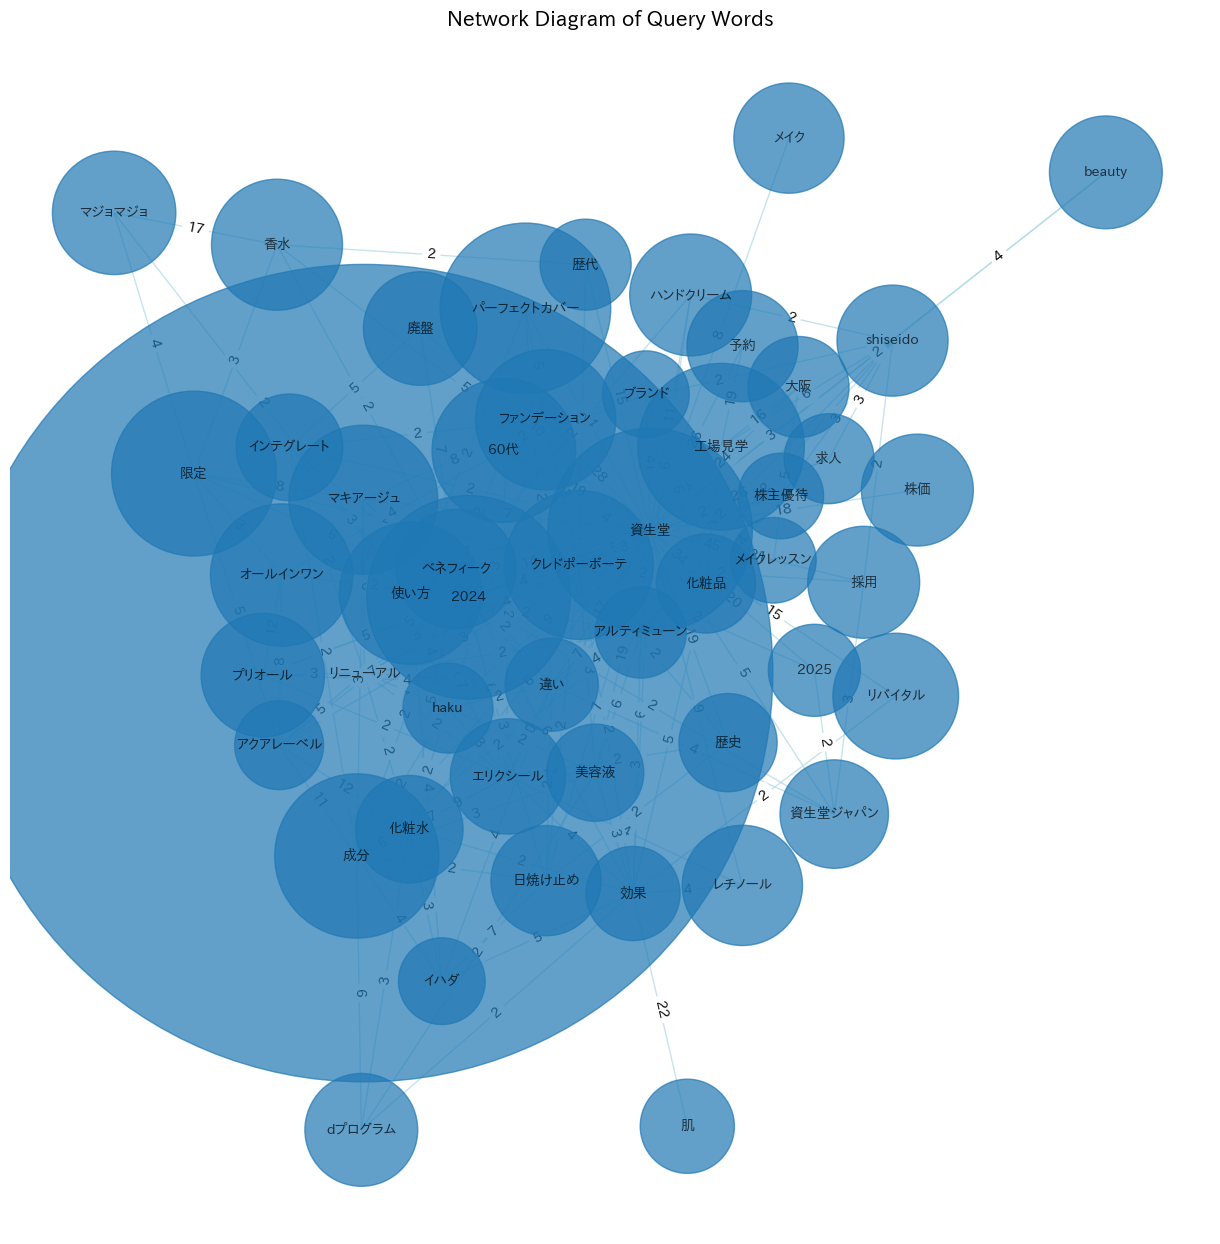

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib  # Import japanize_matplotlib after installing matplotlib
from matplotlib import font_manager
from itertools import combinations
from collections import Counter

plt.rcParams['font.family'] = 'IPAPGothic'
japanize_matplotlib.japanize()

def create_network_diagram(df, query_column="query", top_n_words=50):
    """
    Creates a network diagram of words used in queries.

    Args:
        df (pd.DataFrame): The input DataFrame containing queries.
        query_column (str): The column name containing the queries.
        top_n_words (int): Number of top words to include based on co-occurrence.

    Returns:
        None: Displays the network diagram.
    """
    # Extract and split words from queries
    all_words = df[query_column].dropna().str.split()
    word_pairs = []

    # Generate co-occurrences for each query
    for words in all_words:
        word_pairs.extend(combinations(sorted(set(words)), 2))  # Unique pairs of words

    # Count co-occurrences
    pair_counts = Counter(word_pairs)

    # Create a graph
    G = nx.Graph()
    for (word1, word2), count in pair_counts.items():
        if count > 1:  # Only include pairs with significant co-occurrences
            G.add_edge(word1, word2, weight=count)

    # Get the top nodes by degree
    top_nodes = dict(sorted(G.degree(weight="weight"), key=lambda x: x[1], reverse=True)[:top_n_words])
    subgraph = G.subgraph(top_nodes.keys())

    # Draw the network diagram
    pos = nx.spring_layout(subgraph, seed=42)
    plt.figure(figsize=(12, 12))
    nx.draw(
        subgraph,
        pos,
        with_labels=True,
        node_size=[v * 100 for v in top_nodes.values()],
        edge_color="lightblue",
        font_size=10,
        font_weight="bold",
        alpha=0.7,
        font_family='IPAPGothic',  # Use Japanese font
    )
    nx.draw_networkx_edge_labels(
        subgraph,
        pos,
        edge_labels={(u, v): d["weight"] for u, v, d in subgraph.edges(data=True)},
        font_family='IPAPGothic',
    )
    plt.title("Network Diagram of Query Words", fontsize=15)#, fontproperties=japanese_font)
    plt.show()

create_network_diagram(df_jp[df_jp['clicks'] > 0])

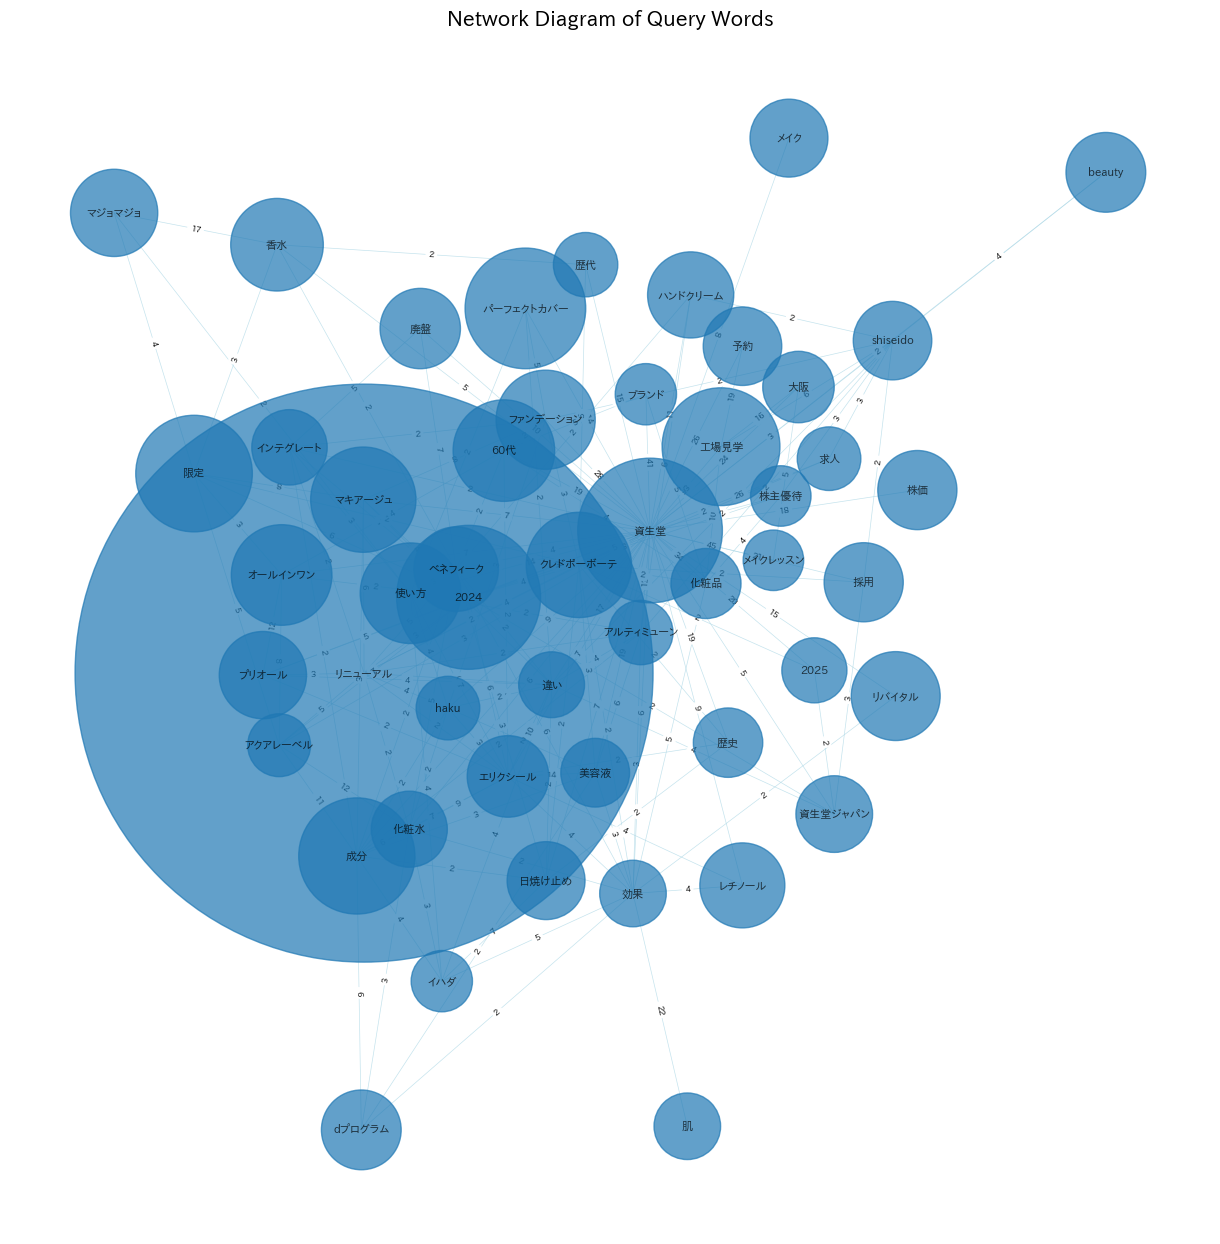

In [ ]:
# prompt: make nodes smaller to avoid overrapp

def create_network_diagram(df, query_column="query", top_n_words=50):
    """
    Creates a network diagram of words used in queries.

    Args:
        df (pd.DataFrame): The input DataFrame containing queries.
        query_column (str): The column name containing the queries.
        top_n_words (int): Number of top words to include based on co-occurrence.

    Returns:
        None: Displays the network diagram.
    """
    # Extract and split words from queries
    all_words = df[query_column].dropna().str.split()
    word_pairs = []

    # Generate co-occurrences for each query
    for words in all_words:
        word_pairs.extend(combinations(sorted(set(words)), 2))  # Unique pairs of words

    # Count co-occurrences
    pair_counts = Counter(word_pairs)

    # Create a graph
    G = nx.Graph()
    for (word1, word2), count in pair_counts.items():
        if count > 1:  # Only include pairs with significant co-occurrences
            G.add_edge(word1, word2, weight=count)

    # Get the top nodes by degree
    top_nodes = dict(sorted(G.degree(weight="weight"), key=lambda x: x[1], reverse=True)[:top_n_words])
    subgraph = G.subgraph(top_nodes.keys())

    # Draw the network diagram
    pos = nx.spring_layout(subgraph, seed=42)
    plt.figure(figsize=(12, 12))
    nx.draw(
        subgraph,
        pos,
        with_labels=True,
        node_size=[v * 50 for v in top_nodes.values()], # Reduced node size
        edge_color="lightblue",
        font_size=8, # Reduced font size
        font_weight="bold",
        alpha=0.7,
        font_family='IPAPGothic',  # Use Japanese font
        width=0.5 #reduced edge width
    )
    nx.draw_networkx_edge_labels(
        subgraph,
        pos,
        edge_labels={(u, v): d["weight"] for u, v, d in subgraph.edges(data=True)},
        font_size=6, # Reduced font size
        font_family='IPAPGothic',
    )
    plt.title("Network Diagram of Query Words", fontsize=15)#, fontproperties=japanese_font)
    plt.show()

create_network_diagram(df_jp[df_jp['clicks'] > 0])

In [ ]:
from pyvis.network import Network
import pandas as pd
from itertools import combinations
from collections import Counter
import networkx as nx
import os

def create_network_diagram_interactive(df, query_column="query", top_n_words=50):
    """
    Creates an interactive network diagram of words used in queries.

    Args:
        df (pd.DataFrame): The input DataFrame containing queries.
        query_column (str): The column name containing the queries.
        top_n_words (int): Number of top words to include based on co-occurrence.

    Returns:
        None: Displays the network diagram in a browser.
    """
    # Extract and split words from queries
    all_words = df[query_column].dropna().str.split()
    word_pairs = []

    # Generate co-occurrences for each query
    for words in all_words:
        word_pairs.extend(combinations(sorted(set(words)), 2))  # Unique pairs of words

    # Count co-occurrences
    pair_counts = Counter(word_pairs)

    # Create a graph
    G = nx.Graph()
    for (word1, word2), count in pair_counts.items():
        if count > 1:  # Only include pairs with significant co-occurrences
            G.add_edge(word1, word2, weight=count)

    # Get the top nodes by degree
    top_nodes = dict(sorted(G.degree(weight="weight"), key=lambda x: x[1], reverse=True)[:top_n_words])
    subgraph = G.subgraph(top_nodes.keys())

    # Create a Pyvis Network
    net = Network(height="750px", width="100%", bgcolor="#ffffff", font_color="black")
    net.barnes_hut()

    # Add nodes and edges with attributes
    for node, degree in subgraph.degree():
        net.add_node(node, label=node, size=degree * 5)

    for edge in subgraph.edges(data=True):
        net.add_edge(edge[0], edge[1], value=edge[2]['weight'])

    # Add title and other details
    net.set_options("""
    const options = {
      "nodes": {
        "shape": "dot",
        "scaling": {
          "min": 10,
          "max": 50
        }
      },
      "edges": {
        "color": {
          "inherit": true
        },
        "smooth": false
      },
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -20000,
          "springLength": 95
        },
        "minVelocity": 0.75
      }
    }
    """)

    output_dir = 'output'  # Or any directory you prefer
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    html_file_path = os.path.join(output_dir, "network_diagram.html")

    # Show the network diagram
    net.show(html_file_path)

create_network_diagram_interactive(df_jp[df_jp['clicks'] > 0])

output/network_diagram.html


AttributeError: 'NoneType' object has no attribute 'render'

In [ ]:
!pip install -q pyvis==0.3.2